In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# 한글
import warnings
warnings.filterwarnings('ignore')
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='Malgun Gothic')

### 전처리
final.csv를 받아서<br>
모델에 넣기 위해서 쓸모없는 column drop 및 integer encoding(label encoding)

In [6]:
df = pd.read_csv("final.csv", index_col = 0, encoding = "utf-8")


In [7]:
df.drop(["시군구", "year_quarter", "addr_road", \
         "transaction_year_month", "transaction_date", \
         "서울_운영_영업_개월_평균", "서울_폐업_영업_개월_평균"], \
        axis = 1, inplace = True)
df["transaction_year"] = df["date"].str.split("-").str[0].astype(int)
df["transaction_month"] = df["date"].str.split("-").str[1].astype(int)
df["transaction_day"] = df["date"].str.split("-").str[2].astype(int)
df.drop("date", axis = 1, inplace = True)

encoder = LabelEncoder()
df["dong_encoded"] = encoder.fit_transform(df["dong"])
df["apt_encoded"] = encoder.fit_transform(df["apt"])
df.drop(["dong", "apt"], axis = 1, inplace = True)

df.rename(columns = {
    "exclusive_use_area": "전용면적",
    "year_of_completion": "건축년도",
    "floor": "층",
    "transaction_real_price": "실거래가",
    "transaction_year": "계약년도",
    "transaction_month": "계약월",
    "transaction_day": "계약일",
    "dong_encoded": "법정동",
    "apt_encoded": "아파트명"
}, inplace = True)
columns = ['소비자태도', '현재생활형편', '미래생활형편', '현재경기판단', '미래경기판단', '내구재구입태도', '주택구입태도', '현재소비지출', '미래소비지출', '순자산', '고용상황', '물가예상']
for column in columns:
    df.rename(columns = {
        column: column + "지수"
    }, inplace = True)
df.rename(columns = {
    "아파트실거래가격지수_서울": "아파트실거래가격지수",
    "아파트실거래가격지수_전국": "아파트실거래가격지수 전국",
    "주택매매가격지수_서울_아파트": "주택매매가격지수"
}, inplace = True)
df.rename(columns = {
    "시장금리(콜)": "시장금리"
}, inplace = True)
df.reset_index(inplace = True, drop = True)

In [8]:
df

전용면적  건축년도   층   실거래가  소비자태도지수  현재생활형편지수  미래생활형편지수  현재경기판단지수  \
0       77.75  1988   5  60000     90.6      81.0      94.9      55.6   
1       77.75  1988   5  65000     90.6      81.0      94.9      55.6   
2       77.75  1988   2  62500     90.6      81.0      94.9      55.6   
3       77.75  1988   6  68000     95.7      86.2     100.4      65.2   
4       79.97  1987   5  73000     90.6      81.0      94.9      55.6   
...       ...   ...  ..    ...      ...       ...       ...       ...   
608042  59.76  1998  13  68000     92.9      76.6      95.2      56.8   
608043  59.76  1998  15  77000     93.2      79.2      97.1      55.0   
608044  57.66  2003   5  30500     89.0      72.9      96.0      46.6   
608045  72.22  2003   4  49500     92.9      76.6      95.2      56.8   
608046  58.46  2003   2  30000     93.2      79.2      97.1      55.0   

        미래경기판단지수  내구재구입태도지수  ...  한강 근접 여부  준공 이래 경과년수  초등학교 개수  중학교 개수  \
0           80.0       88.0  ...         0          27        6       3   
1           80.0       88.0  ...         0          27        6       3   
2           80.0       88.0  ...         0          27        6       3   
3           83.1       89.3  ...         0          27        6       3   
4           80.0       88.0  ...         0          28        6       3   
...          ...        ...  ...       ...         ...      ...     ...   
608042      86.5       81.9  ...         0          23        2       2   
608043      81.6       81.6  ...         0          23        2       2   
608044      86.5       77.6  ...         0          18        2       2   
608045      86.5       81.9  ...         0          18        2       2   
608046      81.6       81.6  ...         0          18        2       2   

        고등학교 개수  계약년도  계약월  계약일  법정동  아파트명  
0             4  2015    1   11    8   604  
1             4  2015    3    3    8   604  
2             4  2015    3    7    8   604  
3             4  2015    8   16    8   604  
4             4  2015    1   29    8   605  
...         ...   ...  ...  ...  ...   ...  
608042        1  2021    4   16  273  6805  
608043        1  2021    7   31  273  6805  
608044        1  2021    2   27  273  6881  
608045        1  2021    5    4  273  6882  
608046        1  2021    7    1  273  6883  

[608047 rows x 72 columns]

In [9]:
df.columns
# '준공 이래 경과년수' : 용어 있나 찾아보기
#  -> 이것 넣으면 건축년도, 거래연도는 빼도 될듯
# 월 -> 계절성이 있을 수 있음
# 전세공급량, 가격이 집값에 영향을 미칠 수 있음

Index(['전용면적', '건축년도', '층', '실거래가', '소비자태도지수', '현재생활형편지수', '미래생활형편지수',
       '현재경기판단지수', '미래경기판단지수', '내구재구입태도지수', '주택구입태도지수', '현재소비지출지수', '미래소비지출지수',
       '순자산지수', '고용상황지수', '물가예상지수', '코스피지수', '코스닥지수', '코스피200', '코스피50',
       '시장금리', '주택매매가격지수', '주택전세가격지수', '아파트실거래가격지수', '아파트실거래가격지수 전국',
       '생산자물가지수', '소비자물가지수', '주택매매가격지수', '법정동별인구수', '단기 COFIX', '기준금리',
       '총 의사 수', '의과 일반의 인원수', '의과 인턴 인원수', '의과 레지던트 인원수', '의과 전문의 인원수',
       '치과 일반의 인원수', '치과 인턴 인원수', '치과 레지던트 인원수', '치과 전문의 인원수', '한방 일반의 인원수',
       '한방 인턴 인원수', '한방 레지던트 인원수', '한방전문의 인원수', '병원 개수', '보건소 개수', '보건지소 개수',
       '상급종합병원 개수', '요양병원 개수', '의원 개수', '정신병원 개수', '산부인과 개수', '종합병원 개수',
       '치과병원 개수', '치과의원 개수', '한방병원 개수', '한의원 개수', '약국 개수', '역 개수', '공원 면적',
       '대공원 개수', '공원 개수', '한강 근접 여부', '준공 이래 경과년수', '초등학교 개수', '중학교 개수',
       '고등학교 개수', '계약년도', '계약월', '계약일', '법정동', '아파트명'],
      dtype='object')

### data setting

In [10]:
X = df[['전용면적', '건축년도', '층', '소비자태도지수', '현재생활형편지수', '미래생활형편지수',
       '현재경기판단지수', '미래경기판단지수', '내구재구입태도지수', '주택구입태도지수', '현재소비지출지수', '미래소비지출지수',
       '순자산지수', '고용상황지수', '물가예상지수', '코스피지수', '코스닥지수', '코스피200', '코스피50',
       '시장금리', '주택매매가격지수', '주택전세가격지수', '아파트실거래가격지수', '아파트실거래가격지수 전국',
       '생산자물가지수', '소비자물가지수', '주택매매가격지수', '법정동별인구수', '단기 COFIX', '기준금리',
       '총 의사 수', '의과 일반의 인원수', '의과 인턴 인원수', '의과 레지던트 인원수', '의과 전문의 인원수',
       '치과 일반의 인원수', '치과 인턴 인원수', '치과 레지던트 인원수', '치과 전문의 인원수', '한방 일반의 인원수',
       '한방 인턴 인원수', '한방 레지던트 인원수', '한방전문의 인원수', '병원 개수', '보건소 개수', '보건지소 개수',
       '상급종합병원 개수', '요양병원 개수', '의원 개수', '정신병원 개수', '산부인과 개수', '종합병원 개수',
       '치과병원 개수', '치과의원 개수', '한방병원 개수', '한의원 개수', '약국 개수', '역 개수', '공원 면적',
       '대공원 개수', '공원 개수', '한강 근접 여부', '준공 이래 경과년수', '초등학교 개수', '중학교 개수',
       '고등학교 개수', '계약년도', '계약월', '계약일', '법정동', '아파트명']]

y = df['실거래가']

# 보통 작업시엔 columns 명은 영어로(띄어쓰기도 x, 대신 언더비(_), 대쉬도 x)
# 시각화 할때 한글로 바꾸는게 일반적

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 0)

print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Train Data :  (425632, 73) (425632,)
Test Data :  (182415, 73) (182415,)


In [ ]:
# 가급적 fit 할 때 시간 체크

In [12]:
%%time
Model_dt = DecisionTreeRegressor(random_state = 0)
Model_dt.fit(X_train, y_train)

CPU times: user 15 s, sys: 99 ms, total: 15.1 s
Wall time: 15.1 s


In [13]:
y_hat = Model_dt.predict(X_test)


In [14]:
y_hat


array([ 89900.,  45000., 154000., ...,  70000.,  96500.,  53500.])

In [15]:
mse2 = mean_squared_error(y_test, y_hat)
np.sqrt(mse2)


10638.213594001452

In [16]:
y.mean()

65752.39449088639

In [17]:
y.min()

700

In [18]:
y.max()

1150000

In [28]:
Model_dt.feature_importances_

array([3.78659061e-01, 8.28149035e-02, 9.43287690e-03, 1.73744803e-04,
       1.74093299e-04, 4.54319369e-04, 1.98827695e-04, 3.56074635e-04,
       1.94006291e-04, 3.55940201e-04, 1.63228241e-04, 2.83749335e-04,
       2.09116962e-04, 2.42202121e-04, 4.76497639e-04, 2.14765013e-03,
       1.65791796e-03, 2.63671304e-03, 2.13356455e-03, 1.11504560e-03,
       4.28168884e-03, 3.85970813e-03, 5.29810248e-03, 6.04422066e-03,
       2.12153864e-03, 2.61305586e-03, 2.20361704e-03, 2.29088767e-03,
       4.29415234e-03, 2.74999897e-02, 5.74819296e-03, 3.33835324e-04,
       6.78856776e-03, 1.37892936e-02, 3.48473141e-04, 1.04396102e-02,
       6.77518135e-03, 1.85643968e-03, 2.94516518e-04, 3.49743852e-03,
       2.19237059e-02, 3.59377876e-03, 2.23334702e-02, 2.12973325e-04,
       2.34597864e-02, 2.67309733e-03, 2.22681629e-03, 6.11781537e-04,
       3.74178890e-04, 2.31428659e-03, 7.55861098e-03, 7.57237428e-05,
       1.14444781e-04, 3.16261204e-04, 1.41633504e-03, 1.58661051e-03,
      

In [30]:
len(Model_dt.feature_importances_)

73

In [ ]:
71 -> 73

In [35]:
columns1 = ['전용면적', '건축년도', '층', '소비자태도지수', \
           '현재생활형편지수', '미래생활형편지수', \
           '현재경기판단지수', '미래경기판단지수', '내구재구입태도지수', \
           '주택구입태도지수', '현재소비지출지수', '미래소비지출지수',
           '순자산지수', '고용상황지수', '물가예상지수', '코스피지수', \
           '코스닥지수', '코스피200', '코스피50',
           '시장금리', '주택매매가격지수', '주택전세가격지수', \
           '아파트실거래가격지수', '아파트실거래가격지수 전국',
           '생산자물가지수', '소비자물가지수', '주택매매가격지수', \
           '법정동별인구수', '단기 COFIX', '기준금리',
           '총 의사 수', '의과 일반의 인원수', '의과 인턴 인원수', \
           '의과 레지던트 인원수', '의과 전문의 인원수',
           '치과 일반의 인원수', '치과 인턴 인원수', '치과 레지던트 인원수', \
           '치과 전문의 인원수', '한방 일반의 인원수',
           '한방 인턴 인원수', '한방 레지던트 인원수', '한방전문의 인원수', \
           '병원 개수', '보건소 개수', '보건지소 개수',
           '상급종합병원 개수', '요양병원 개수', '의원 개수', \
           '정신병원 개수', '산부인과 개수', '종합병원 개수',
           '치과병원 개수', '치과의원 개수', '한방병원 개수', \
           '한의원 개수', '약국 개수', '역 개수', '공원 면적',
           '대공원 개수', '공원 개수', '한강 근접 여부', \
           '준공 이래 경과년수', '초등학교 개수', '중학교 개수',
           '고등학교 개수', '계약년도', '계약월', '계약일', '법정동', '아파트명', '1', '2']

In [25]:
columns1 = ['전용면적', '건축년도']

In [34]:
len(columns1)

71

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


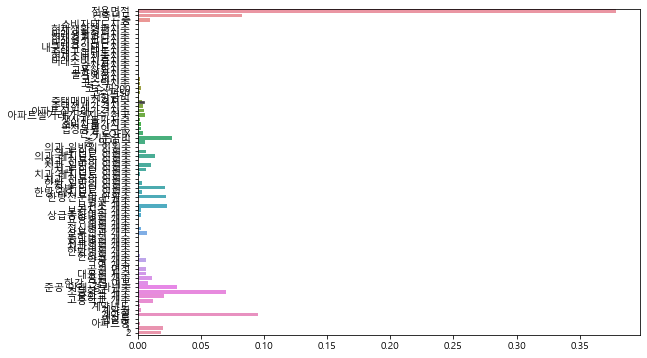

In [36]:
plt.figure(figsize = (9, 6))
sns.barplot(Model_dt.feature_importances_,
            columns1)
plt.show()

In [ ]:
plt.figure(figsize = (9, 6))
sns.barplot(Model_pr.feature_importances_,
            ['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
plt.show()

In [ ]:
['전용면적', '건축년도', '층', '소비자태도지수', '현재생활형편지수', '미래생활형편지수',
       '현재경기판단지수', '미래경기판단지수', '내구재구입태도지수', '주택구입태도지수', '현재소비지출지수', '미래소비지출지수',
       '순자산지수', '고용상황지수', '물가예상지수', '코스피지수', '코스닥지수', '코스피200', '코스피50',
       '시장금리', '주택매매가격지수', '주택전세가격지수', '아파트실거래가격지수', '아파트실거래가격지수 전국',
       '생산자물가지수', '소비자물가지수', '주택매매가격지수', '법정동별인구수', '단기 COFIX', '기준금리',
       '총 의사 수', '의과 일반의 인원수', '의과 인턴 인원수', '의과 레지던트 인원수', '의과 전문의 인원수',
       '치과 일반의 인원수', '치과 인턴 인원수', '치과 레지던트 인원수', '치과 전문의 인원수', '한방 일반의 인원수',
       '한방 인턴 인원수', '한방 레지던트 인원수', '한방전문의 인원수', '병원 개수', '보건소 개수', '보건지소 개수',
       '상급종합병원 개수', '요양병원 개수', '의원 개수', '정신병원 개수', '산부인과 개수', '종합병원 개수',
       '치과병원 개수', '치과의원 개수', '한방병원 개수', '한의원 개수', '약국 개수', '역 개수', '공원 면적',
       '대공원 개수', '공원 개수', '한강 근접 여부', '준공 이래 경과년수', '초등학교 개수', '중학교 개수',
       '고등학교 개수', '계약년도', '계약월', '계약일', '법정동', '아파트명']

In [ ]:
실거래가 기준 
단위 구간별 오차 확인

feature selection


In [ ]:
2015.1월 ~ 2021.7월
시계열 쓸꺼면 lstm,arima
shuffle -> False

max_depth (프루닝)

In [ ]:
연 column, 월 column

In [ ]:
모델선정
모델별 hyperparameter tuning

In [ ]:

print(accuracy_score(y_test, y_hat))
print(precision_score(y_test, y_hat, average = None))
print(recall_score(y_test, y_hat, average = None))

In [38]:
!nvidia-smi

Wed Oct 13 11:33:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# sklearn -> cpu

In [ ]:
# 부스팅계열 - lightgbm같은것들은 gpu 코드가 따로 있음

In [3]:
!ls

eda_v_1.ipynb  final.csv  nohup.out


In [44]:
pd.set_option('display.max_row',100)
pd.set_option('display.max_column', 100)

In [5]:
df = pd.read_csv('final.csv', index_col=0)


In [6]:
df.head()

year_quarter                   시군구 dong addr_road             apt  \
0       2015Q1  201501 서울특별시 강남구 개포동  개포동   언주로 103  개포2차현대아파트(220)   
1       2015Q1  201503 서울특별시 강남구 개포동  개포동   언주로 103  개포2차현대아파트(220)   
2       2015Q1  201503 서울특별시 강남구 개포동  개포동   언주로 103  개포2차현대아파트(220)   
3       2015Q3  201508 서울특별시 강남구 개포동  개포동   언주로 103  개포2차현대아파트(220)   
4       2015Q1  201501 서울특별시 강남구 개포동  개포동     언주로 3  개포6차우성아파트1동~8동   

   exclusive_use_area  year_of_completion transaction_year_month  \
0               77.75                1988             2015-01-01   
1               77.75                1988             2015-03-01   
2               77.75                1988             2015-03-01   
3               77.75                1988             2015-08-01   
4               79.97                1987             2015-01-01   

   transaction_date  floor  transaction_real_price  서울_운영_영업_개월_평균  \
0                11      5                   60000            94.0   
1                 3      5                   65000            94.0   
2                 7      2                   62500            94.0   
3                16      6                   68000            95.0   
4                29      5                   73000            94.0   

   서울_폐업_영업_개월_평균  소비자태도  현재생활형편  미래생활형편  현재경기판단  미래경기판단  내구재구입태도  주택구입태도  \
0            46.0   90.6    81.0    94.9    55.6    80.0     88.0    98.2   
1            46.0   90.6    81.0    94.9    55.6    80.0     88.0    98.2   
2            46.0   90.6    81.0    94.9    55.6    80.0     88.0    98.2   
3            47.0   95.7    86.2   100.4    65.2    83.1     89.3    91.0   
4            46.0   90.6    81.0    94.9    55.6    80.0     88.0    98.2   

   현재소비지출  미래소비지출   순자산  고용상황   물가예상    코스피지수   코스닥지수  코스피200    코스피50  \
0   112.5    96.7  94.2  73.1  130.9  1949.26  591.58  249.88  1611.74   
1   112.5    96.7  94.2  73.1  130.9  2041.03  650.49  257.28  1636.78   
2   112.5    96.7  94.2  73.1  130.9  2041.03  650.49  257.28  1636.78   
3   106.4    95.0  92.4  79.0  131.6  1941.49  687.11  232.80  1426.79   
4   112.5    96.7  94.2  73.1  130.9  1949.26  591.58  249.88  1611.74   

   시장금리(콜)  주택매매가격지수  주택전세가격지수  아파트실거래가격지수_서울  아파트실거래가격지수_전국  생산자물가지수  \
0     1.99    90.570    92.992           80.6           90.9   100.89   
1     1.83    91.151    93.862           82.1           92.4   100.84   
2     1.83    91.151    93.862           82.1           92.4   100.84   
3     1.49    93.120    96.250           85.6           95.6    99.83   
4     1.99    90.570    92.992           80.6           90.9   100.89   

   소비자물가지수  주택매매가격지수_서울_아파트  법정동별인구수        date  단기 COFIX  기준금리  총 의사 수  \
0    99.77             74.6  84144.0  2015-01-11      2.05   2.0   105.0   
1    99.72             75.2  84144.0  2015-03-03      1.94   2.0   105.0   
2    99.72             75.2  84144.0  2015-03-07      1.93   2.0   105.0   
3   100.37             77.6  84144.0  2015-08-16      1.43   1.5   105.0   
4    99.77             74.6  84144.0  2015-01-29      1.97   2.0   105.0   

   의과 일반의 인원수  의과 인턴 인원수  의과 레지던트 인원수  의과 전문의 인원수  치과 일반의 인원수  치과 인턴 인원수  \
0         4.0        0.0          0.0        50.0        22.0        0.0   
1         4.0        0.0          0.0        50.0        22.0        0.0   
2         4.0        0.0          0.0        50.0        22.0        0.0   
3         4.0        0.0          0.0        50.0        22.0        0.0   
4         4.0        0.0          0.0        50.0        22.0        0.0   

   치과 레지던트 인원수  치과 전문의 인원수  한방 일반의 인원수  한방 인턴 인원수  한방 레지던트 인원수  한방전문의 인원수  \
0          0.0         4.0        19.0        0.0          0.0        6.0   
1          0.0         4.0        19.0        0.0          0.0        6.0   
2          0.0         4.0        19.0        0.0          0.0        6.0   
3          0.0         4.0        19.0        0.0          0.0        6.0   
4          0.0         4.0        19.0        0.0          0.0        6.0   

   병원 개수  보건소 개수  보건지

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 608047 entries, 0 to 614266
Data columns (total 77 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   year_quarter            608047 non-null  object 
 1   시군구                     608047 non-null  object 
 2   dong                    608047 non-null  object 
 3   addr_road               608047 non-null  object 
 4   apt                     608047 non-null  object 
 5   exclusive_use_area      608047 non-null  float64
 6   year_of_completion      608047 non-null  int64  
 7   transaction_year_month  608047 non-null  object 
 8   transaction_date        608047 non-null  int64  
 9   floor                   608047 non-null  int64  
 10  transaction_real_price  608047 non-null  int64  
 11  서울_운영_영업_개월_평균          603257 non-null  float64
 12  서울_폐업_영업_개월_평균          603257 non-null  float64
 13  소비자태도                   608047 non-null  float64
 14  현재생활형편              

In [8]:
# 서울_운영_영업_개월_평균, 서울_폐업_영업_개월_평균 -> drop
# 왜냐면 데이터가 6월까지밖에 없음


In [9]:
df.columns

Index(['year_quarter', '시군구', 'dong', 'addr_road', 'apt', 'exclusive_use_area',
       'year_of_completion', 'transaction_year_month', 'transaction_date',
       'floor', 'transaction_real_price', '서울_운영_영업_개월_평균', '서울_폐업_영업_개월_평균',
       '소비자태도', '현재생활형편', '미래생활형편', '현재경기판단', '미래경기판단', '내구재구입태도', '주택구입태도',
       '현재소비지출', '미래소비지출', '순자산', '고용상황', '물가예상', '코스피지수', '코스닥지수', '코스피200',
       '코스피50', '시장금리(콜)', '주택매매가격지수', '주택전세가격지수', '아파트실거래가격지수_서울',
       '아파트실거래가격지수_전국', '생산자물가지수', '소비자물가지수', '주택매매가격지수_서울_아파트', '법정동별인구수',
       'date', '단기 COFIX', '기준금리', '총 의사 수', '의과 일반의 인원수', '의과 인턴 인원수',
       '의과 레지던트 인원수', '의과 전문의 인원수', '치과 일반의 인원수', '치과 인턴 인원수', '치과 레지던트 인원수',
       '치과 전문의 인원수', '한방 일반의 인원수', '한방 인턴 인원수', '한방 레지던트 인원수', '한방전문의 인원수',
       '병원 개수', '보건소 개수', '보건지소 개수', '상급종합병원 개수', '요양병원 개수', '의원 개수',
       '정신병원 개수', '산부인과 개수', '종합병원 개수', '치과병원 개수', '치과의원 개수', '한방병원 개수',
       '한의원 개수', '약국 개수', '역 개수', '공원 면적', '대공원 개수', '공원 개수', '한강 근접 여부',
       '준공 이래 경과년수', '초등학

In [10]:
# 'dong', 'addr_road', 'exclusive_use_area', 'year_of_completion', 'floor', 'transaction_real_price'남김

df_temp = df.drop(['year_quarter', '시군구', \
                   'apt',  'transaction_year_month', \
                   'transaction_date', \
                   '서울_운영_영업_개월_평균', '서울_폐업_영업_개월_평균', 'date'], axis=1)

In [11]:
# transaction_year transaction_month 추가해야됨

In [12]:
df_temp

dong   addr_road  exclusive_use_area  year_of_completion  floor  \
0       개포동     언주로 103               77.75                1988      5   
1       개포동     언주로 103               77.75                1988      5   
2       개포동     언주로 103               77.75                1988      2   
3       개포동     언주로 103               77.75                1988      6   
4       개포동       언주로 3               79.97                1987      5   
...     ...         ...                 ...                 ...    ...   
614260  중화동     동일로 752               59.76                1998     13   
614261  중화동     동일로 752               59.76                1998     15   
614264  중화동  동일로144길 74               57.66                2003      5   
614265  중화동  동일로144길 74               72.22                2003      4   
614266  중화동  동일로144길 74               58.46                2003      2   

        transaction_real_price  소비자태도  현재생활형편  미래생활형편  현재경기판단  미래경기판단  \
0                        60000   90.6    81.0    94.9    55.6    80.0   
1                        65000   90.6    81.0    94.9    55.6    80.0   
2                        62500   90.6    81.0    94.9    55.6    80.0   
3                        68000   95.7    86.2   100.4    65.2    83.1   
4                        73000   90.6    81.0    94.9    55.6    80.0   
...                        ...    ...     ...     ...     ...     ...   
614260                   68000   92.9    76.6    95.2    56.8    86.5   
614261                   77000   93.2    79.2    97.1    55.0    81.6   
614264                   30500   89.0    72.9    96.0    46.6    86.5   
614265                   49500   92.9    76.6    95.2    56.8    86.5   
614266                   30000   93.2    79.2    97.1    55.0    81.6   

        내구재구입태도  주택구입태도  현재소비지출  미래소비지출   순자산  고용상황   물가예상    코스피지수    코스닥지수  \
0          88.0    98.2   112.5    96.7  94.2  73.1  130.9  1949.26   591.58   
1          88.0    98.2   112.5    96.7  94.2  73.1  130.9  2041.03   650.49   
2          88.0    98.2   112.5    96.7  94.2  73.1  130.9  2041.03   650.49   
3          89.3    91.0   106.4    95.0  92.4  79.0  131.6  1941.49   687.11   
4          88.0    98.2   112.5    96.7  94.2  73.1  130.9  1949.26   591.58   
...         ...     ...     ...     ...   ...   ...    ...      ...      ...   
614260     81.9    56.4   100.3    87.3  95.3  78.5  131.4  3147.86   983.45   
614261     81.6    58.0   102.6    87.8  95.7  76.0  133.3  3202.32  1031.14   
614264     77.6    53.8    98.0    85.6  95.6  74.5  135.4  3012.95   913.94   
614265     81.9    56.4   100.3    87.3  95.3  78.5  131.4  3203.92   981.78   
614266     81.6    58.0   102.6    87.8  95.7  76.0  133.3  3202.32  1031.14   

        코스피200    코스피50  시장금리(콜)  주택매매가격지수  주택전세가격지수  아파트실거래가격지수_서울  \
0       249.88  1611.74     1.99    90.570    92.992           80.6   
1       257.28  1636.78     1.83    91.151    93.862           82.1   
2       257.28  1636.78     1.83    91.151    93.862           82.1   
3       232.80  1426.79     1.49    93.120    96.250           85.6   
4       249.88  1611.74     1.99    90.570    92.992           80.6   
...        ...      ...      ...       ...       ...            ...   
614260  422.36  2940.72     0.48   114.039   109.136          164.4   
614261  423.91  2949.94     0.53   118.002   111.715          174.8   
614264  409.91  2885.52     0.49   111.375   107.730          162.9   
614265  427.91  2964.66     0.48   115.133   109.761          167.3   
614266  423.91  2949.94     0.53   118.002   111.715          174.8   

        아파트실거래가격지수_전국  생산자물가지수  소비자물가지수  주택매매가격지수_서울_아파트  법정동별인구수  단기 COFIX  \
0                90.9   100.89    99.77             74.6  84144.0      2.05   
1                92.4   100.84    99.72             75.2  84144.0      1.94   
2                92.4   100.84    99.72             75.2  84144.0      1.93   
3                95.6    99.83   100.37             77.6  84144.0      1.43   
4                90.9   100.89  

In [13]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 608047 entries, 0 to 614266
Data columns (total 69 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   dong                    608047 non-null  object 
 1   addr_road               608047 non-null  object 
 2   exclusive_use_area      608047 non-null  float64
 3   year_of_completion      608047 non-null  int64  
 4   floor                   608047 non-null  int64  
 5   transaction_real_price  608047 non-null  int64  
 6   소비자태도                   608047 non-null  float64
 7   현재생활형편                  608047 non-null  float64
 8   미래생활형편                  608047 non-null  float64
 9   현재경기판단                  608047 non-null  float64
 10  미래경기판단                  608047 non-null  float64
 11  내구재구입태도                 608047 non-null  float64
 12  주택구입태도                  608047 non-null  float64
 13  현재소비지출                  608047 non-null  float64
 14  미래소비지출              

In [14]:
df_temp.columns

Index(['dong', 'addr_road', 'exclusive_use_area', 'year_of_completion',
       'floor', 'transaction_real_price', '소비자태도', '현재생활형편', '미래생활형편',
       '현재경기판단', '미래경기판단', '내구재구입태도', '주택구입태도', '현재소비지출', '미래소비지출', '순자산',
       '고용상황', '물가예상', '코스피지수', '코스닥지수', '코스피200', '코스피50', '시장금리(콜)',
       '주택매매가격지수', '주택전세가격지수', '아파트실거래가격지수_서울', '아파트실거래가격지수_전국', '생산자물가지수',
       '소비자물가지수', '주택매매가격지수_서울_아파트', '법정동별인구수', '단기 COFIX', '기준금리', '총 의사 수',
       '의과 일반의 인원수', '의과 인턴 인원수', '의과 레지던트 인원수', '의과 전문의 인원수', '치과 일반의 인원수',
       '치과 인턴 인원수', '치과 레지던트 인원수', '치과 전문의 인원수', '한방 일반의 인원수', '한방 인턴 인원수',
       '한방 레지던트 인원수', '한방전문의 인원수', '병원 개수', '보건소 개수', '보건지소 개수', '상급종합병원 개수',
       '요양병원 개수', '의원 개수', '정신병원 개수', '산부인과 개수', '종합병원 개수', '치과병원 개수',
       '치과의원 개수', '한방병원 개수', '한의원 개수', '약국 개수', '역 개수', '공원 면적', '대공원 개수',
       '공원 개수', '한강 근접 여부', '준공 이래 경과년수', '초등학교 개수', '중학교 개수', '고등학교 개수'],
      dtype='object')

In [15]:
df_temp_temp = df_temp.iloc[:, 2:]

In [16]:
df_temp_temp

exclusive_use_area  year_of_completion  floor  transaction_real_price  \
0                    77.75                1988      5                   60000   
1                    77.75                1988      5                   65000   
2                    77.75                1988      2                   62500   
3                    77.75                1988      6                   68000   
4                    79.97                1987      5                   73000   
...                    ...                 ...    ...                     ...   
614260               59.76                1998     13                   68000   
614261               59.76                1998     15                   77000   
614264               57.66                2003      5                   30500   
614265               72.22                2003      4                   49500   
614266               58.46                2003      2                   30000   

        소비자태도  현재생활형편  미래생활형편  현재경기판단  미래경기판단  내구재구입태도  주택구입태도  현재소비지출  \
0        90.6    81.0    94.9    55.6    80.0     88.0    98.2   112.5   
1        90.6    81.0    94.9    55.6    80.0     88.0    98.2   112.5   
2        90.6    81.0    94.9    55.6    80.0     88.0    98.2   112.5   
3        95.7    86.2   100.4    65.2    83.1     89.3    91.0   106.4   
4        90.6    81.0    94.9    55.6    80.0     88.0    98.2   112.5   
...       ...     ...     ...     ...     ...      ...     ...     ...   
614260   92.9    76.6    95.2    56.8    86.5     81.9    56.4   100.3   
614261   93.2    79.2    97.1    55.0    81.6     81.6    58.0   102.6   
614264   89.0    72.9    96.0    46.6    86.5     77.6    53.8    98.0   
614265   92.9    76.6    95.2    56.8    86.5     81.9    56.4   100.3   
614266   93.2    79.2    97.1    55.0    81.6     81.6    58.0   102.6   

        미래소비지출   순자산  고용상황   물가예상    코스피지수    코스닥지수  코스피200    코스피50  시장금리(콜)  \
0         96.7  94.2  73.1  130.9  1949.26   591.58  249.88  1611.74     1.99   
1         96.7  94.2  73.1  130.9  2041.03   650.49  257.28  1636.78     1.83   
2         96.7  94.2  73.1  130.9  2041.03   650.49  257.28  1636.78     1.83   
3         95.0  92.4  79.0  131.6  1941.49   687.11  232.80  1426.79     1.49   
4         96.7  94.2  73.1  130.9  1949.26   591.58  249.88  1611.74     1.99   
...        ...   ...   ...    ...      ...      ...     ...      ...      ...   
614260    87.3  95.3  78.5  131.4  3147.86   983.45  422.36  2940.72     0.48   
614261    87.8  95.7  76.0  133.3  3202.32  1031.14  423.91  2949.94     0.53   
614264    85.6  95.6  74.5  135.4  3012.95   913.94  409.91  2885.52     0.49   
614265    87.3  95.3  78.5  131.4  3203.92   981.78  427.91  2964.66     0.48   
614266    87.8  95.7  76.0  133.3  3202.32  1031.14  423.91  2949.94     0.53   

        주택매매가격지수  주택전세가격지수  아파트실거래가격지수_서울  아파트실거래가격지수_전국  생산자물가지수  소비자물가지수  \
0         90.570    92.992           80.6           90.9   100.89    99.77   
1         91.151    93.862           82.1           92.4   100.84    99.72   
2         91.151    93.862           82.1           92.4   100.84    99.72   
3         93.120    96.250           85.6           95.6    99.83   100.37   
4         90.570    92.992           80.6           90.9   100.89    99.77   
...          ...       ...            ...            ...      ...      ...   
614260   114.039   109.136          164.4          128.8   108.06   107.39   
614261   118.002   111.715          174.8          137.1   110.28   107.61   
614264   111.375   107.730          162.9          125.4   105.91   107.00   
614265   115.133   109.761          167.3          130.9   108.65   107.46   
614266   118.002   111.715          174.8          137.1   110.28   107.61   

        주택매매가격지수_서울_아파트  법정동별인구수  단기 COFIX  기준금리  총 의사 수  의과 일반의 인원수  \
0                  74.6  84144.0      2.05   2.0   105.0         4.0   
1                  75.2  84144.0      1.94   2.0   105.0         4.0   
2                  7

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


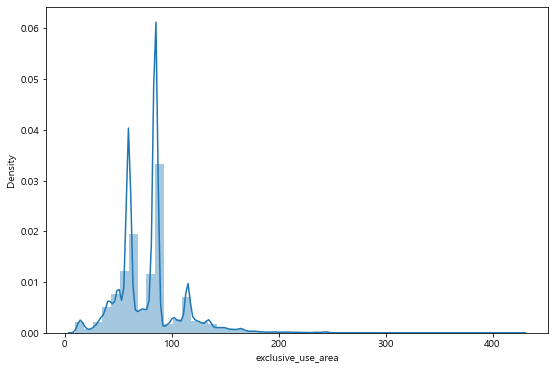

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


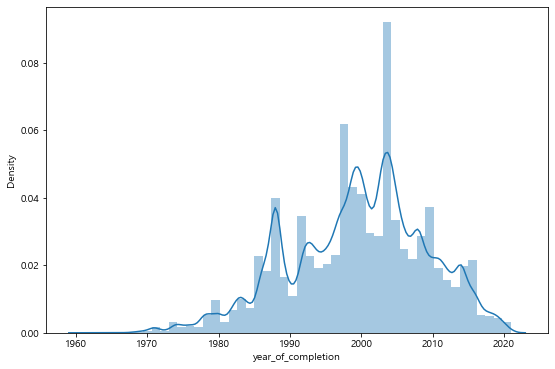

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


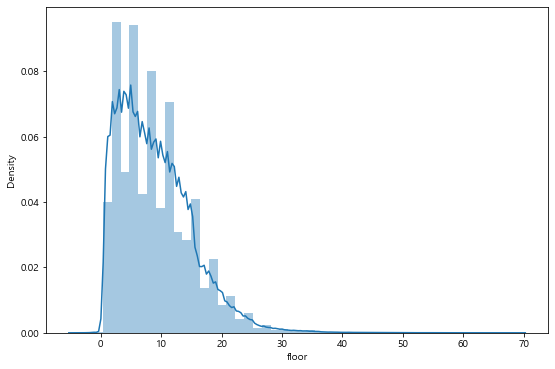

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


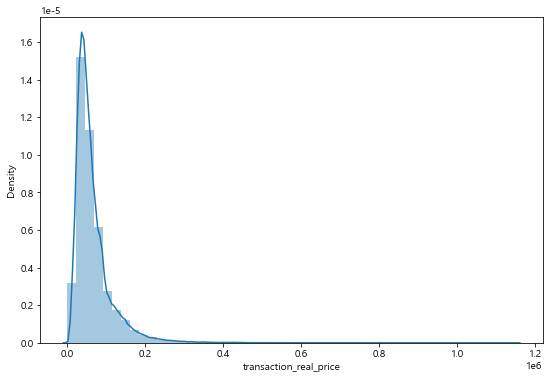

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


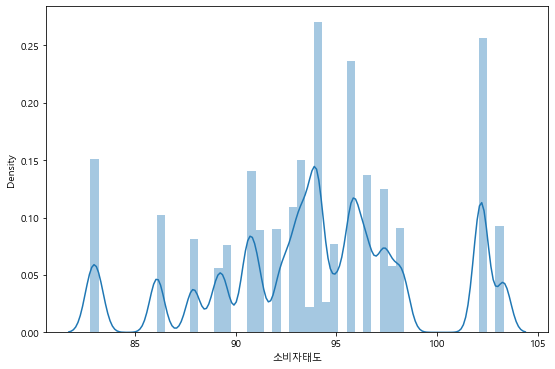

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


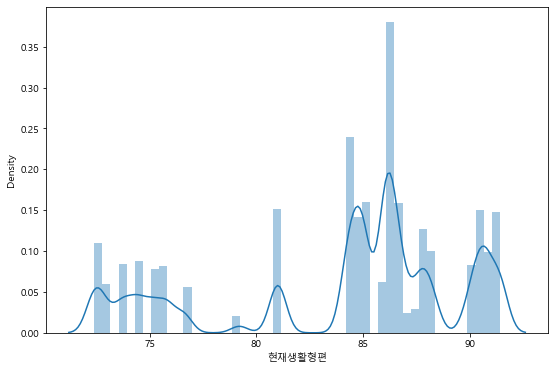

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


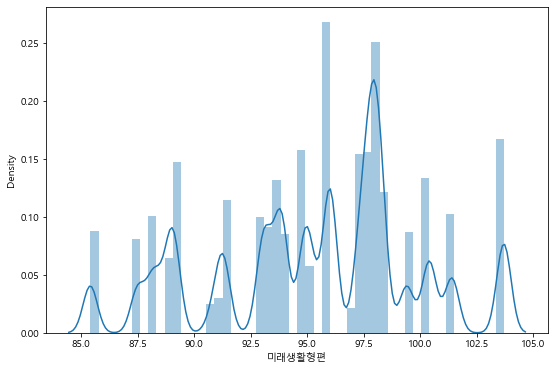

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


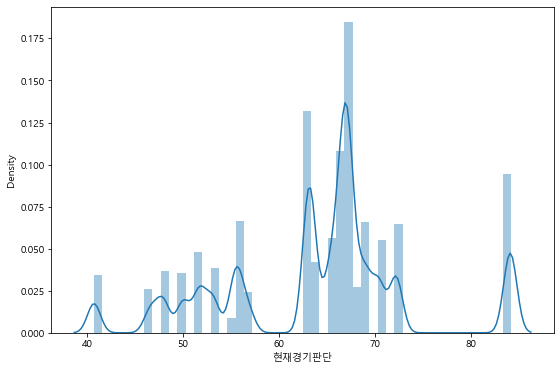

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


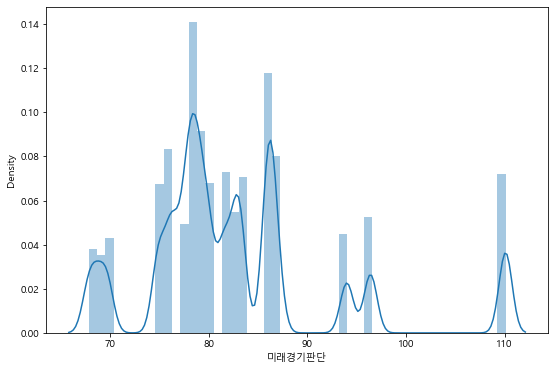

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


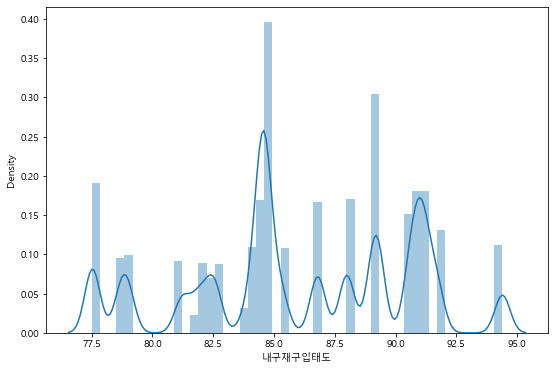

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


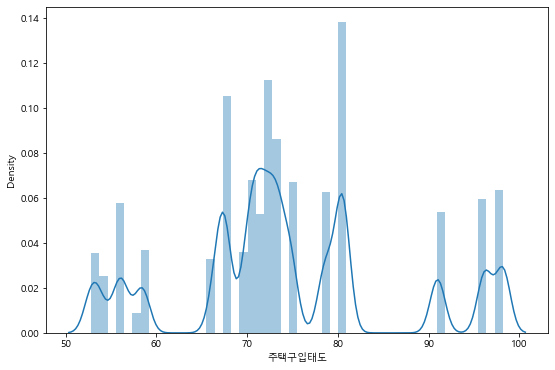

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


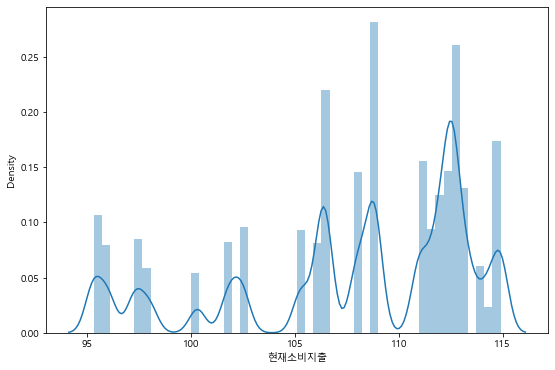

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


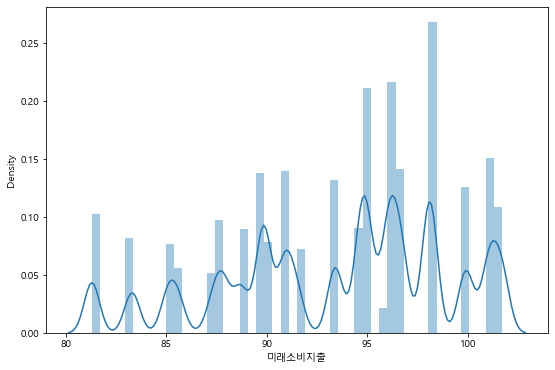

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


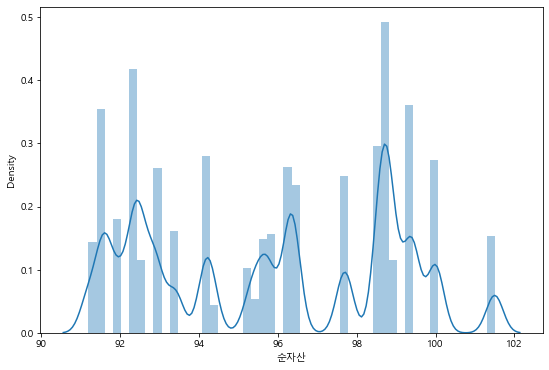

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


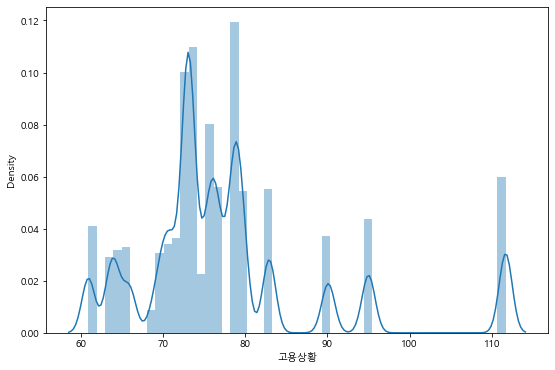

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


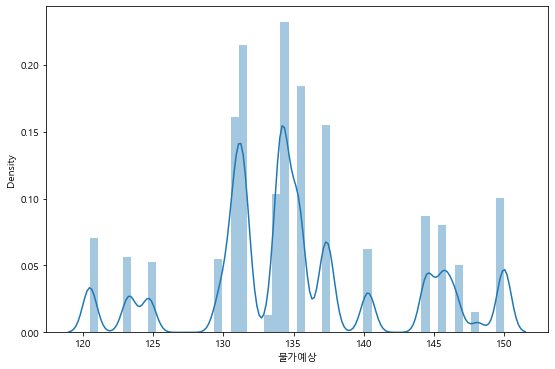

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


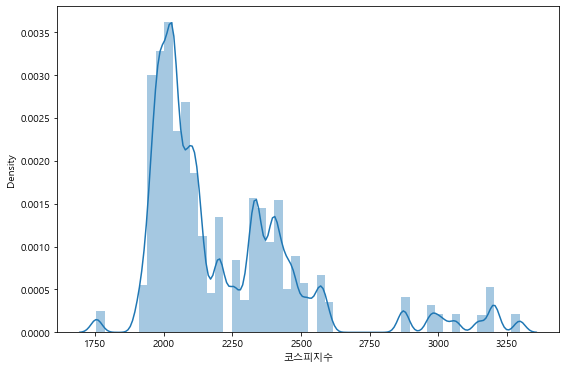

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


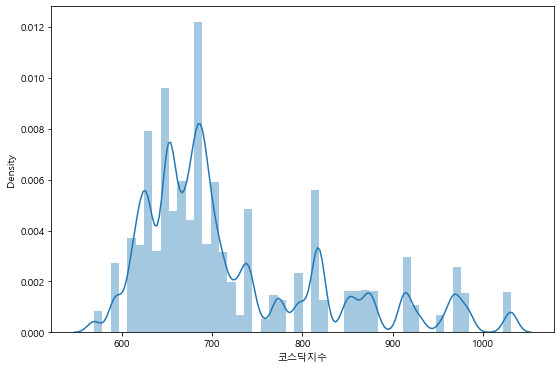

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


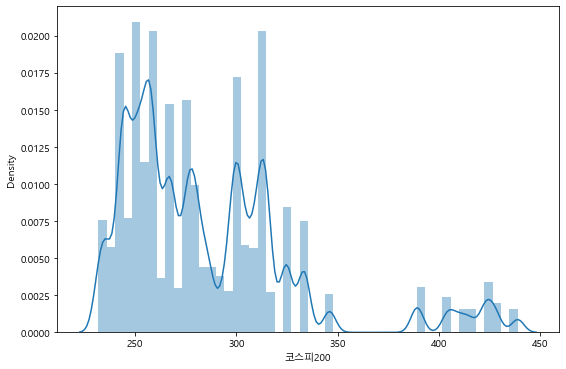

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


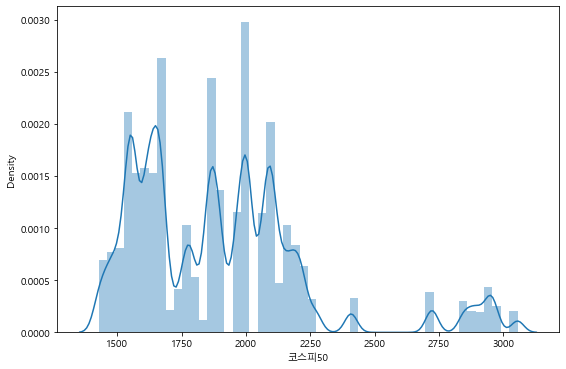

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


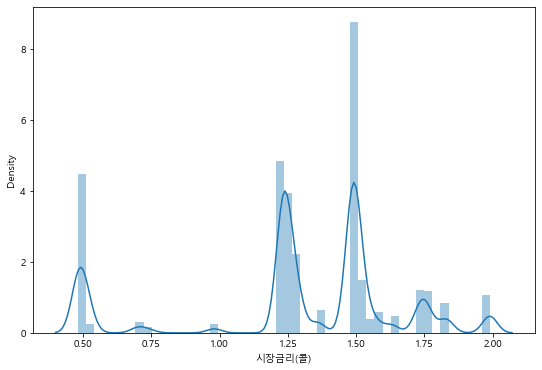

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


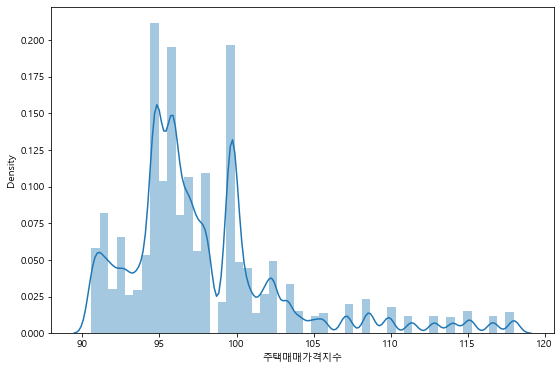

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


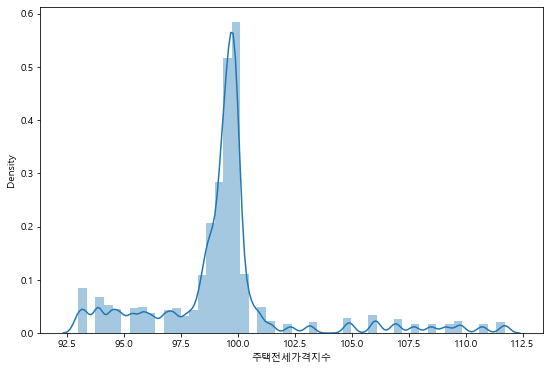

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


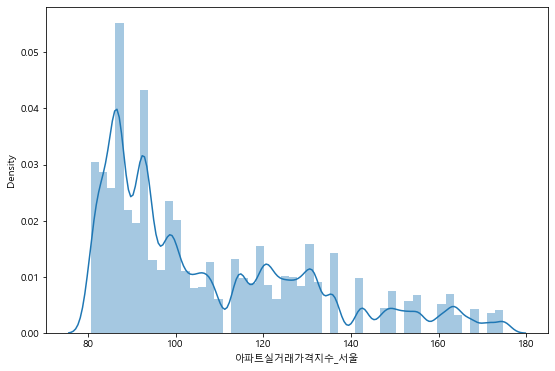

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


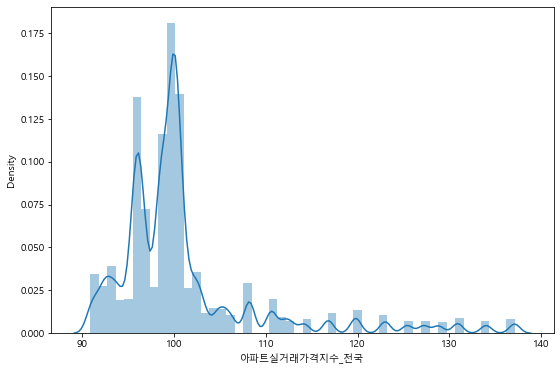

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


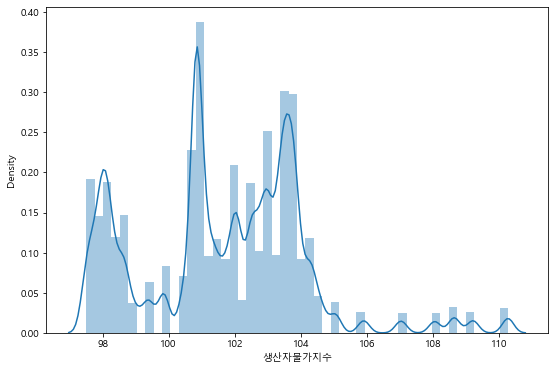

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


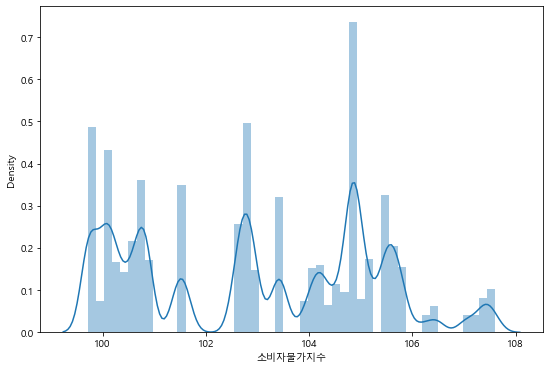

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


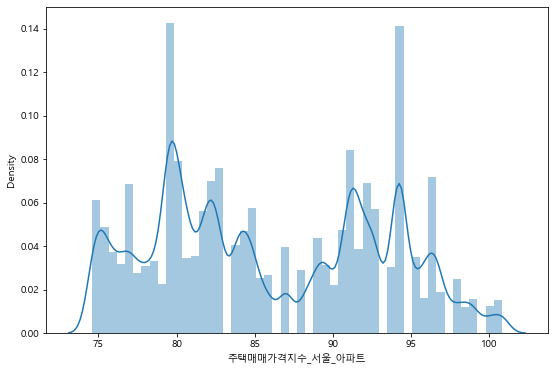

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


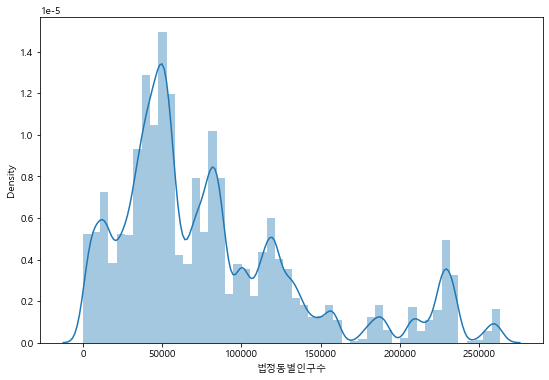

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


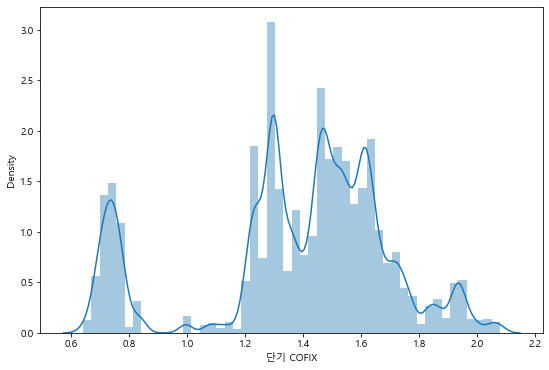

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


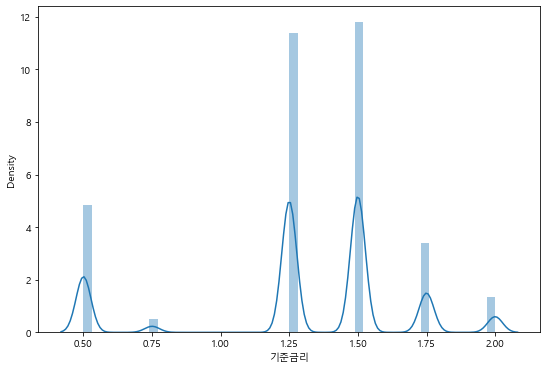

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


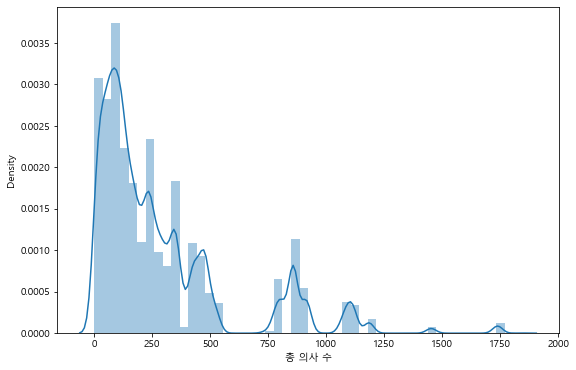

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


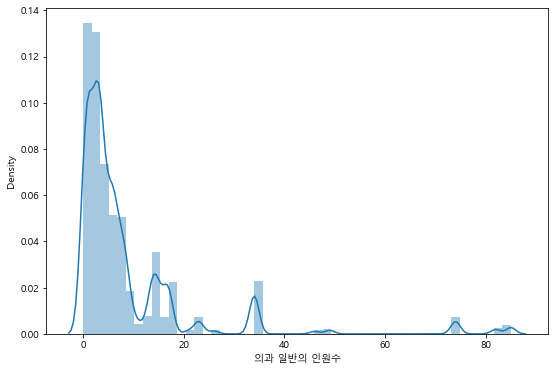

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


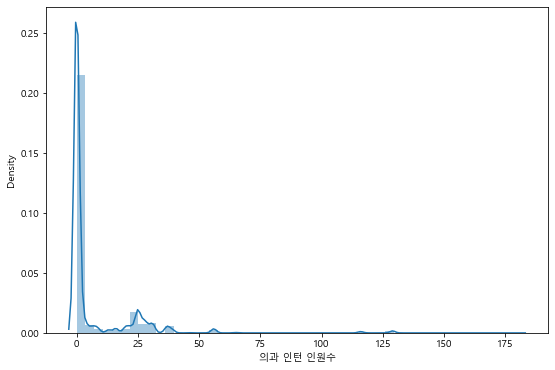

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


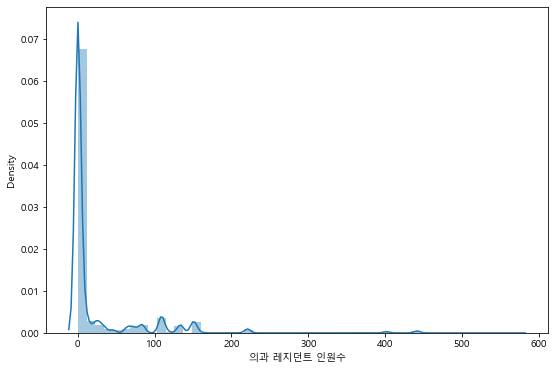

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


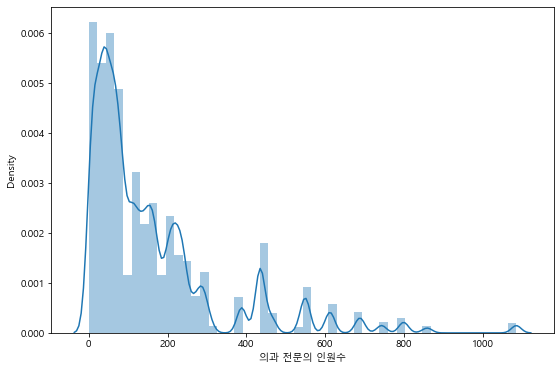

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


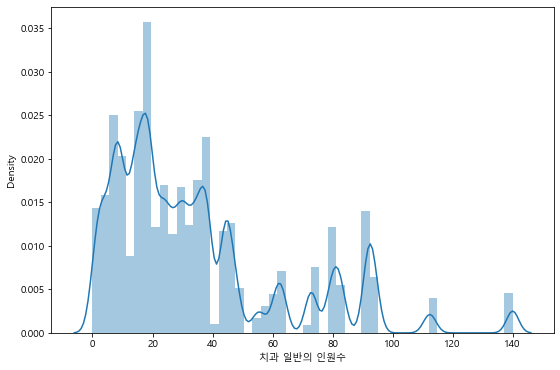

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


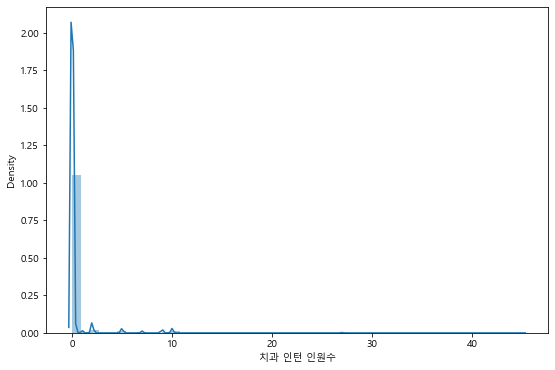

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


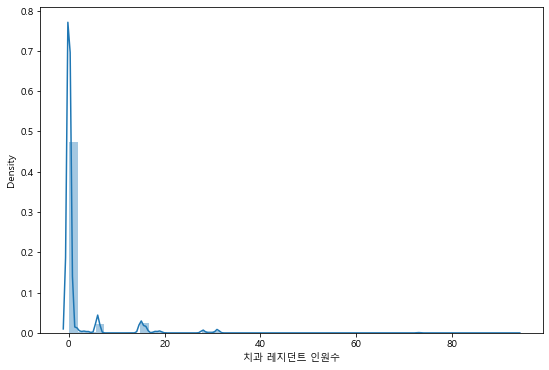

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


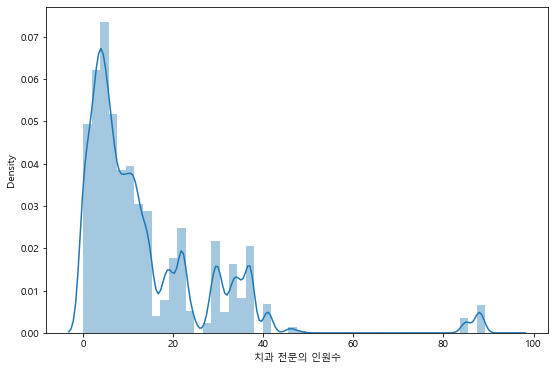

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


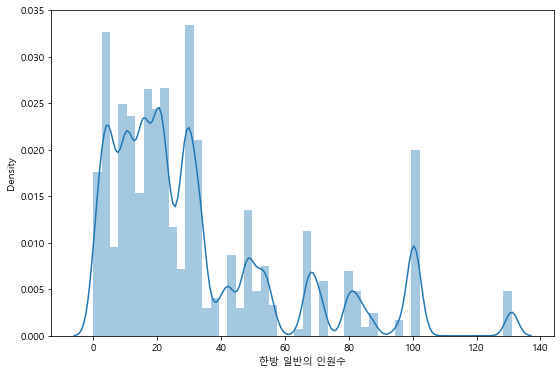

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


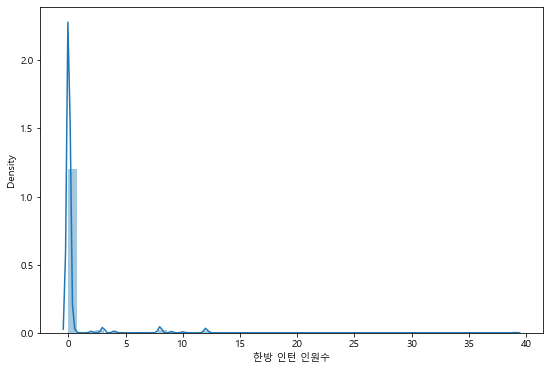

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


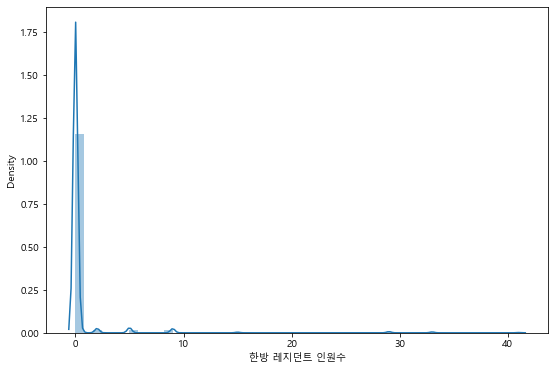

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


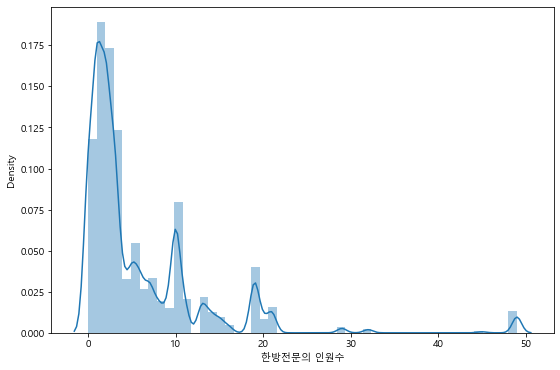

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


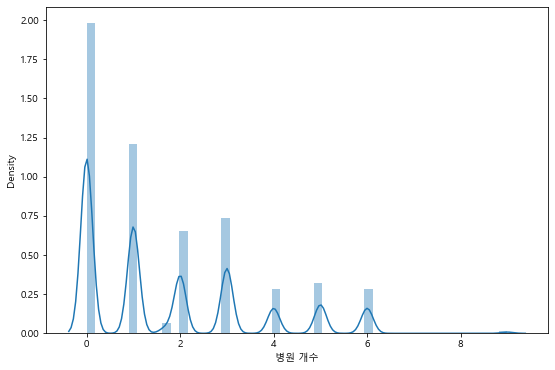

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


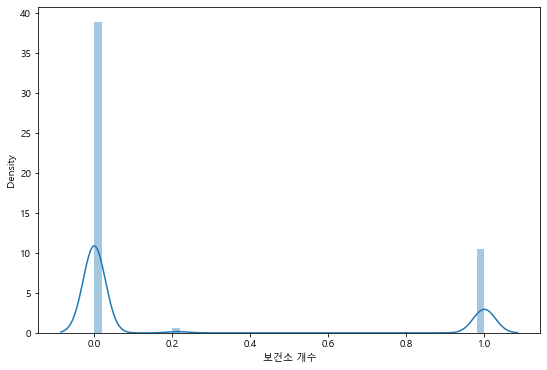

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


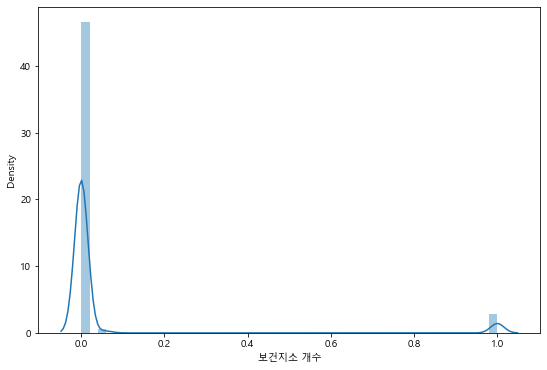

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


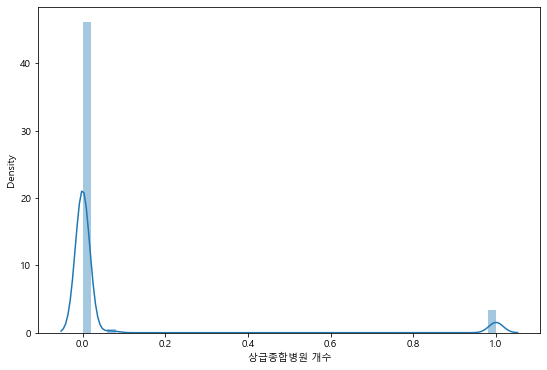

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


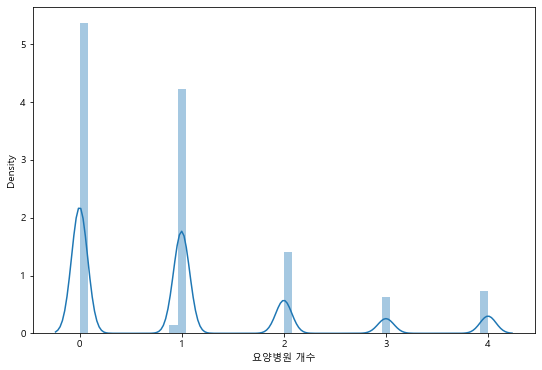

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


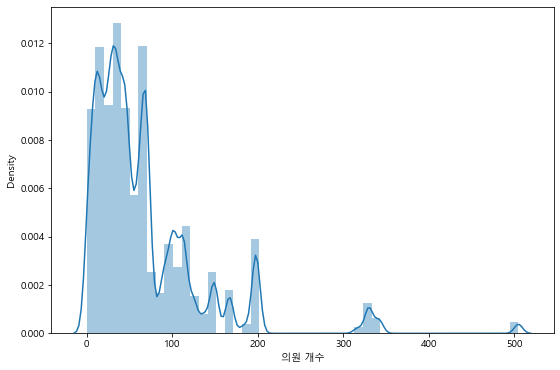

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


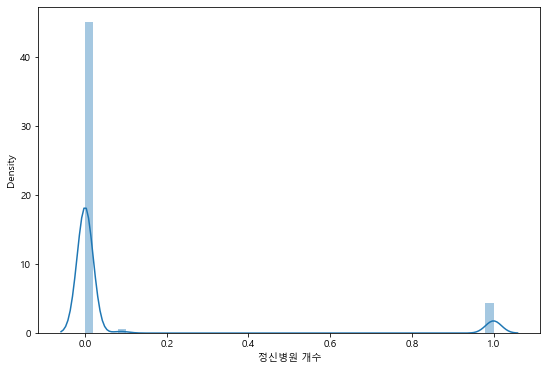

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


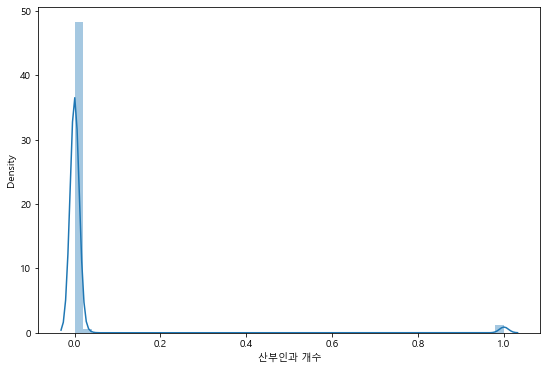

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


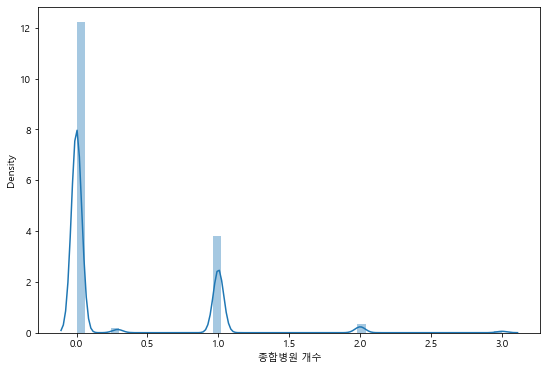

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


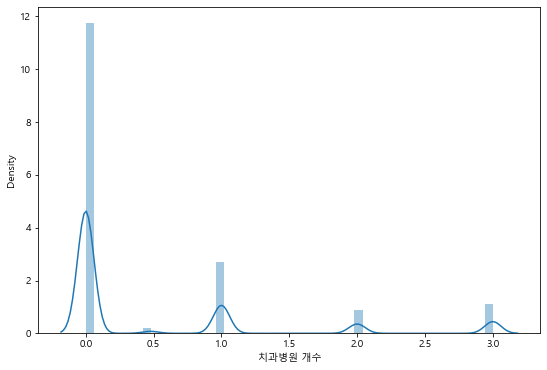

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


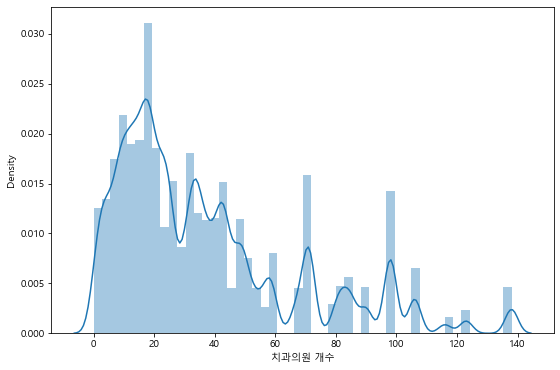

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


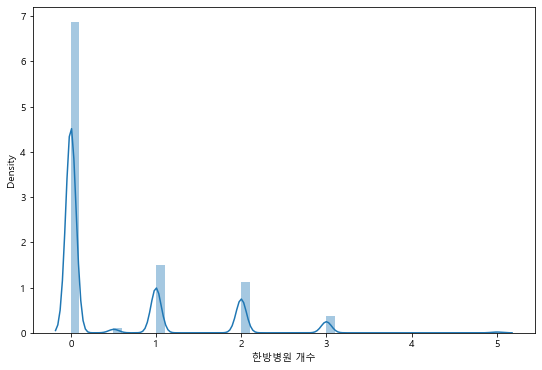

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


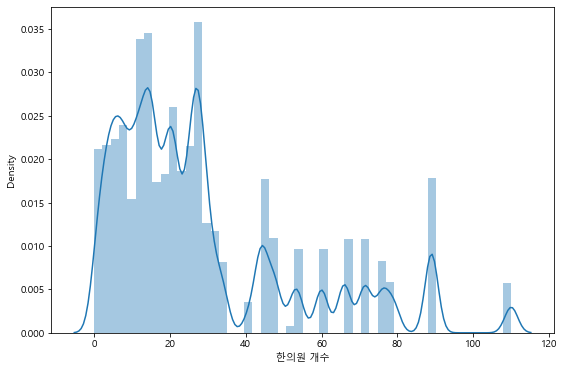

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


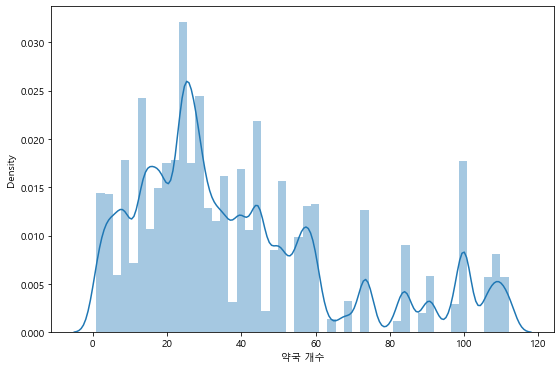

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


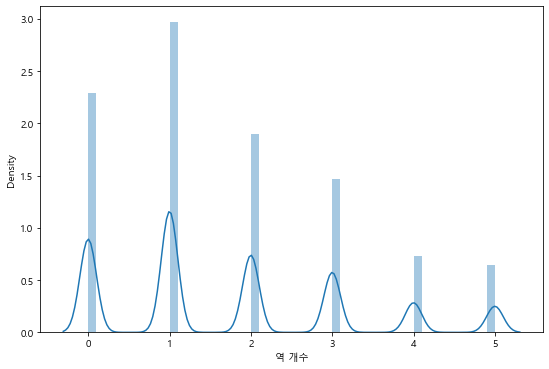

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


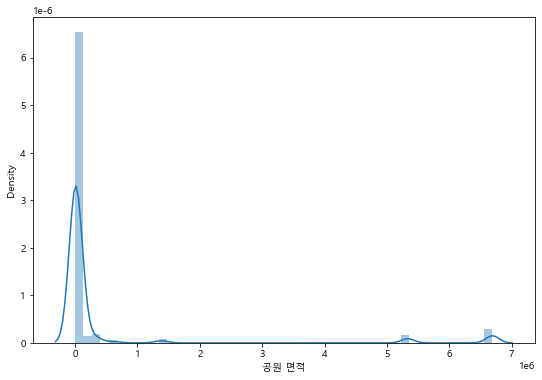

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


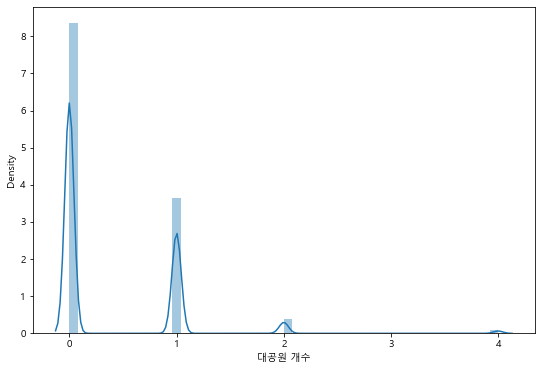

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


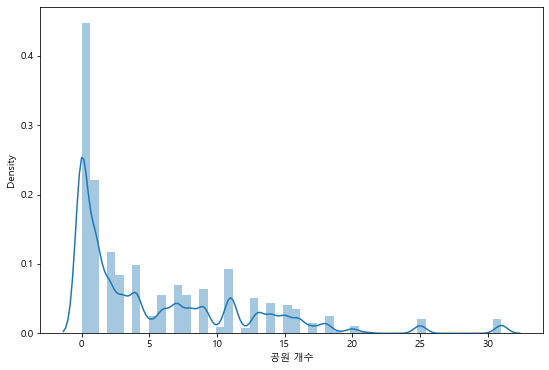

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


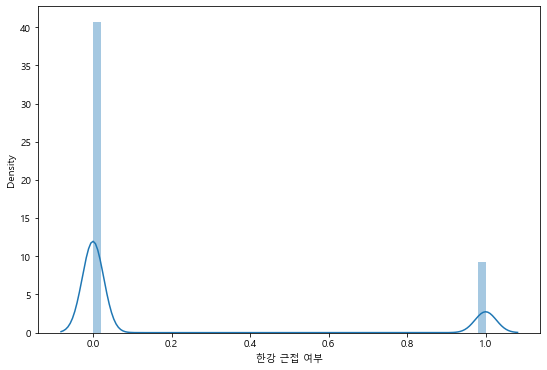

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


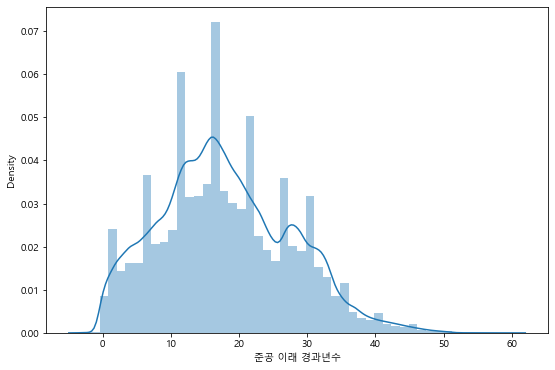

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


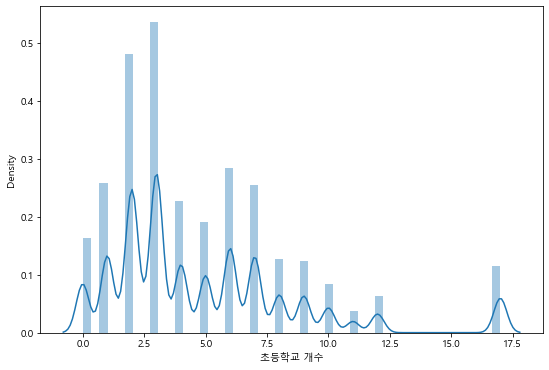

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


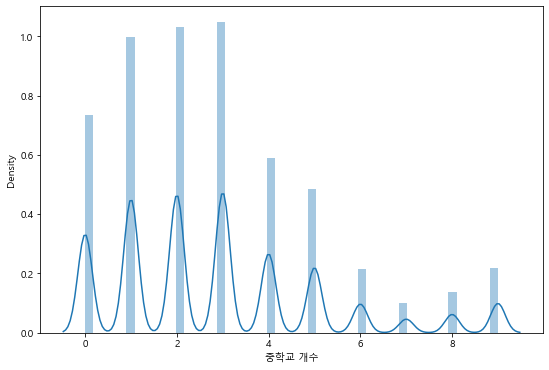

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


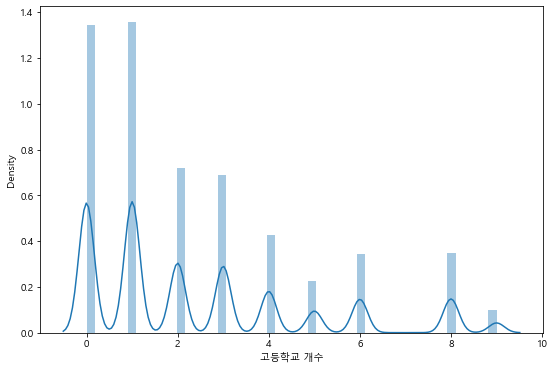

In [17]:
for column in df_temp_temp.columns:
    plt.figure(figsize = (9, 6))
    sns.distplot(df_temp_temp[column],
                 hist = True,
                 kde = True)
    plt.show()

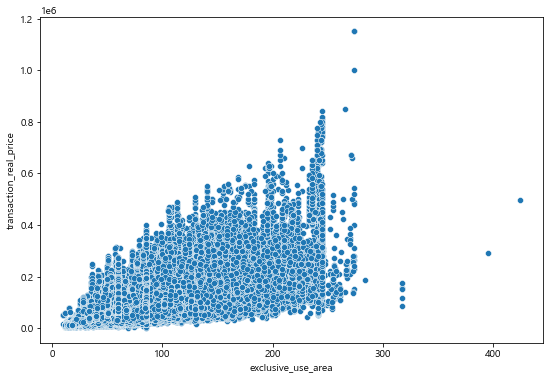

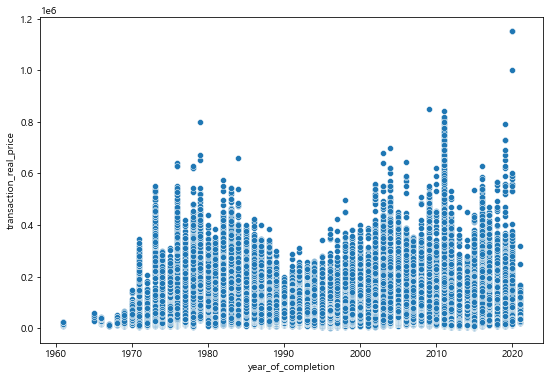

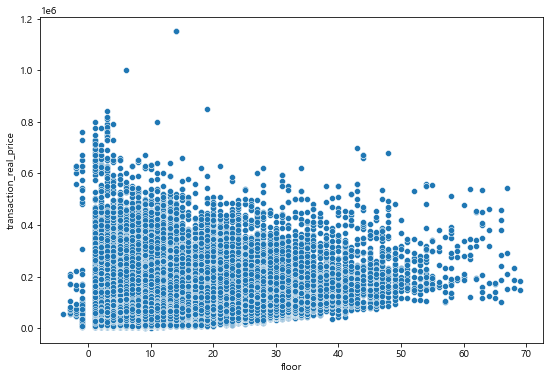

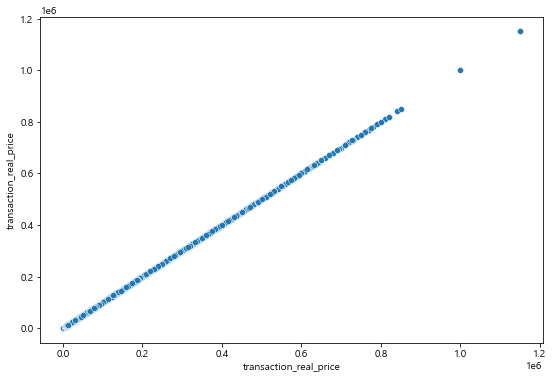

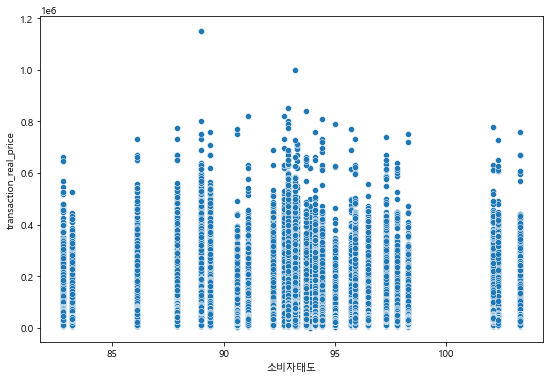

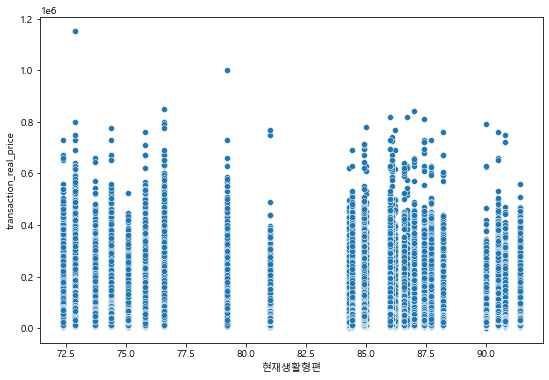

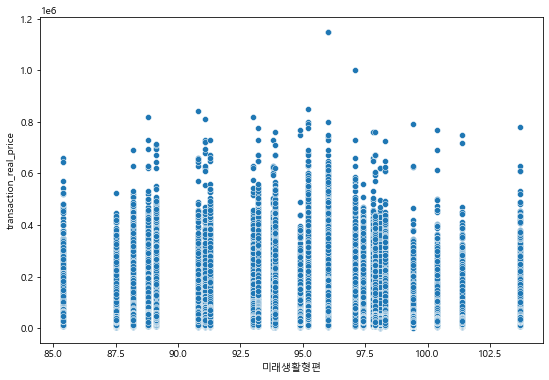

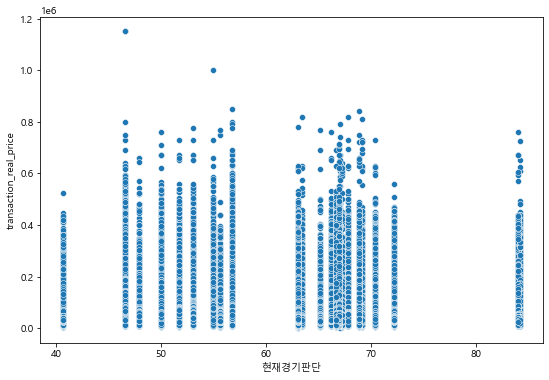

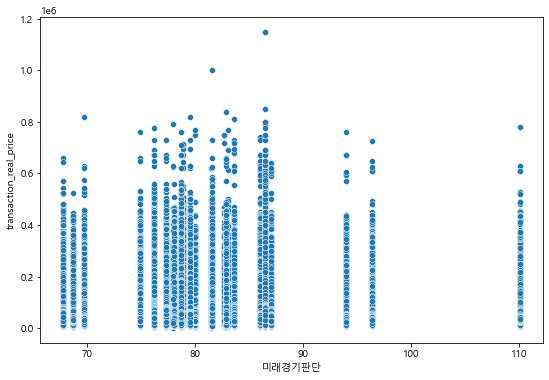

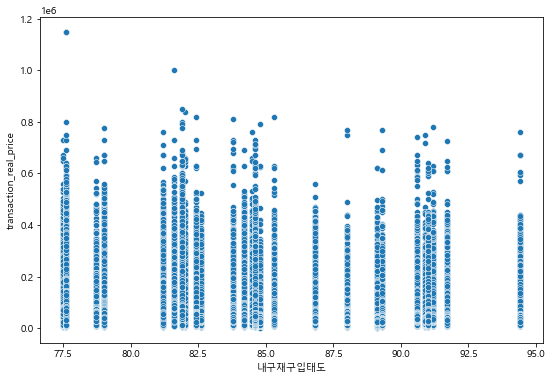

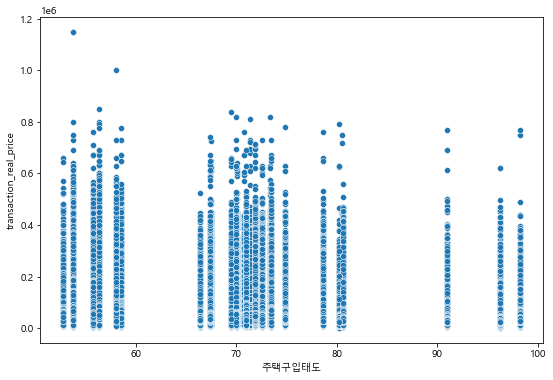

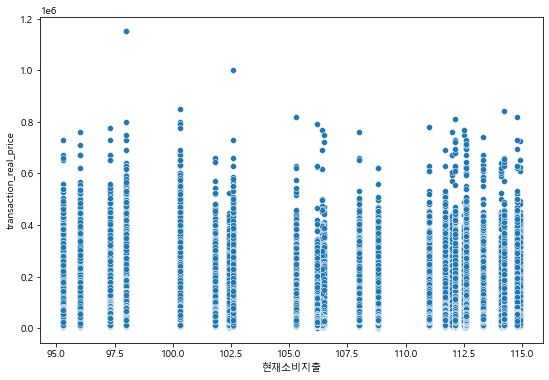

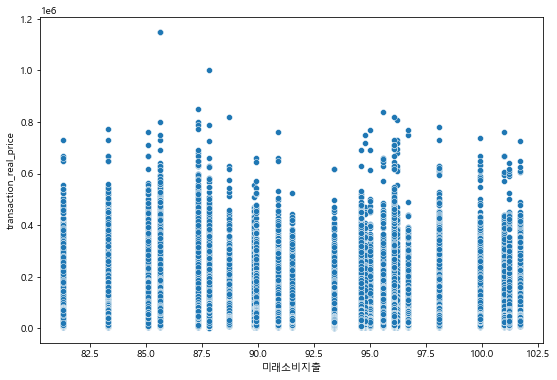

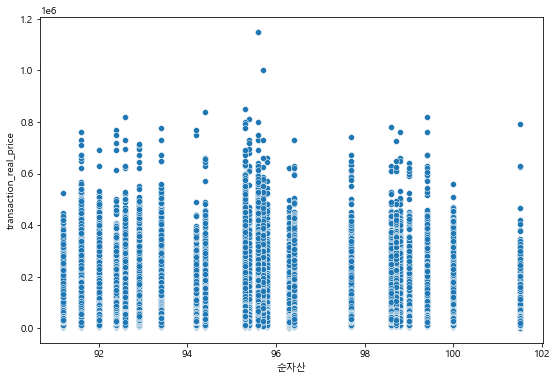

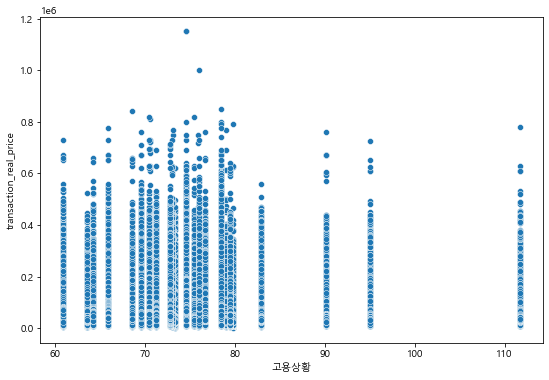

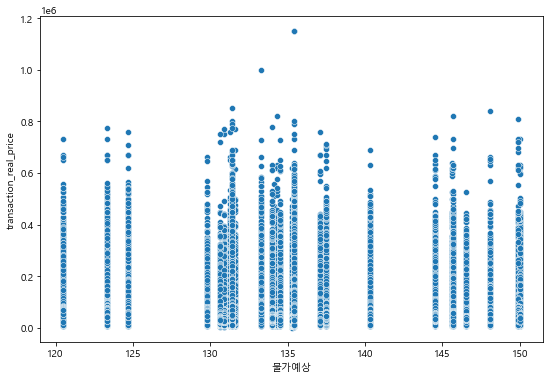

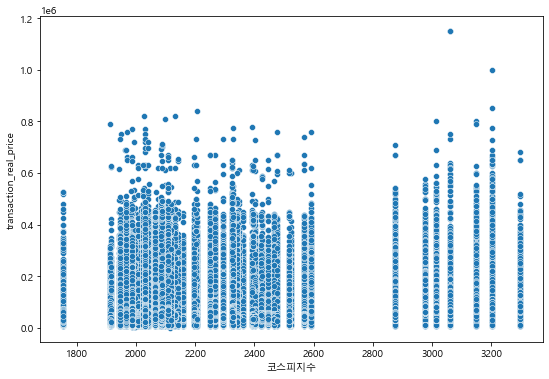

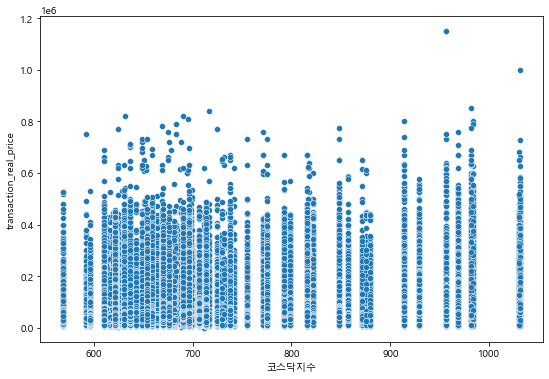

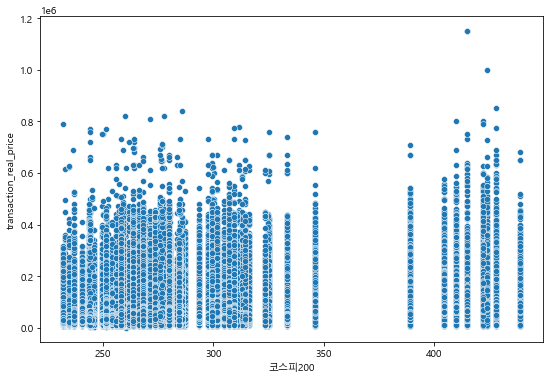

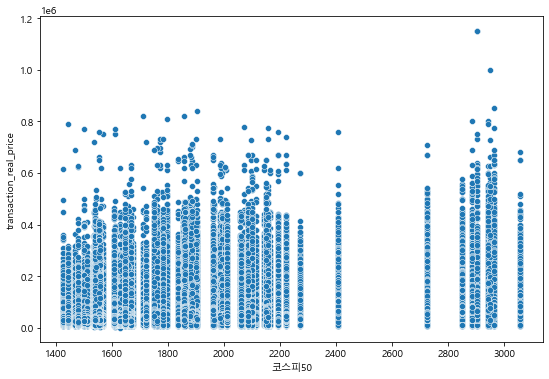

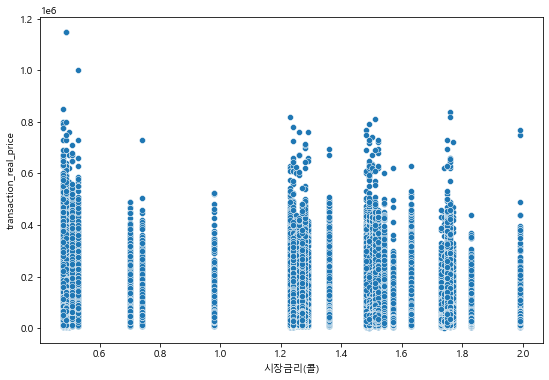

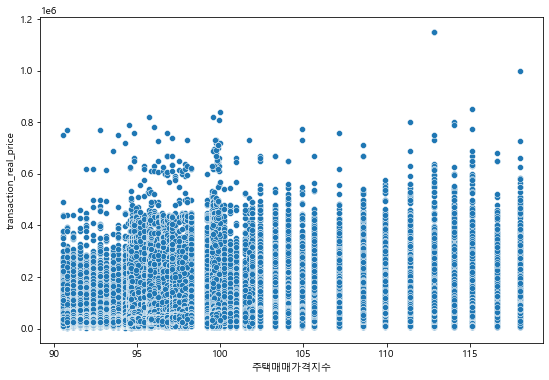

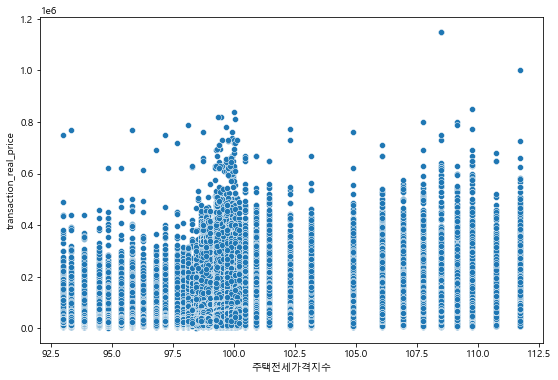

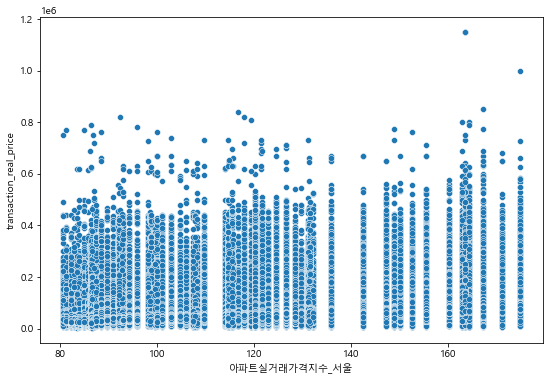

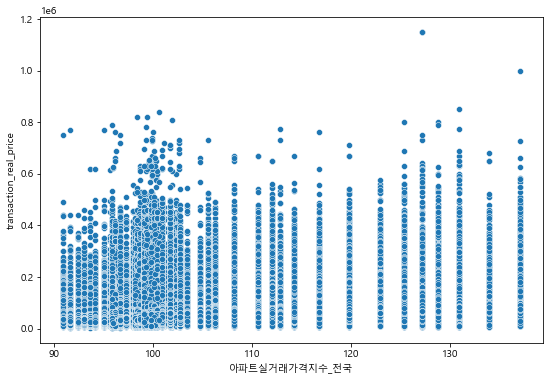

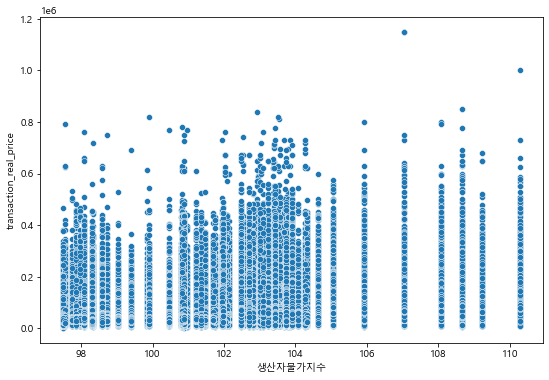

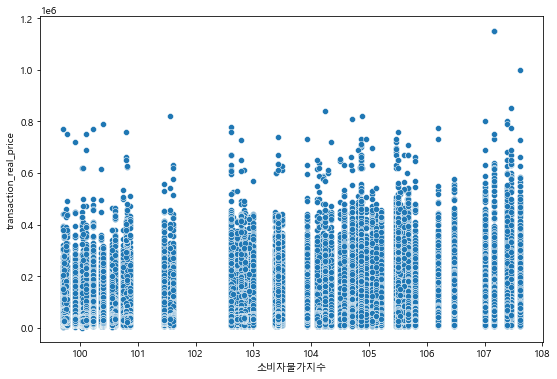

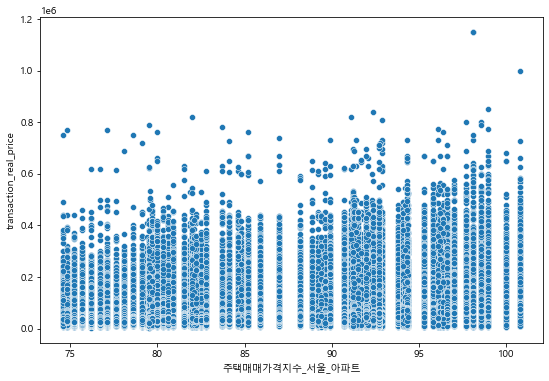

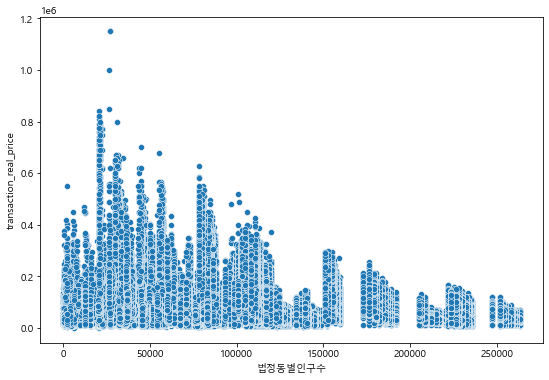

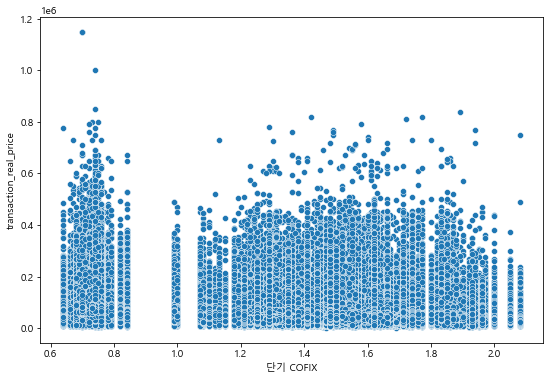

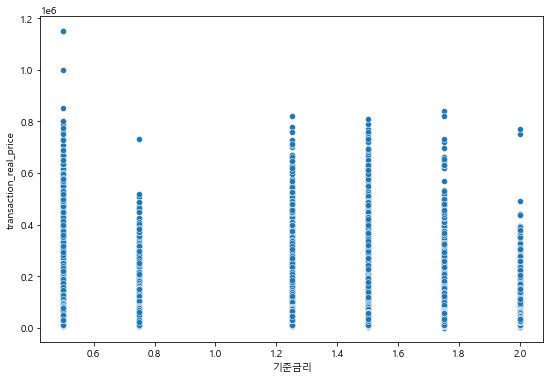

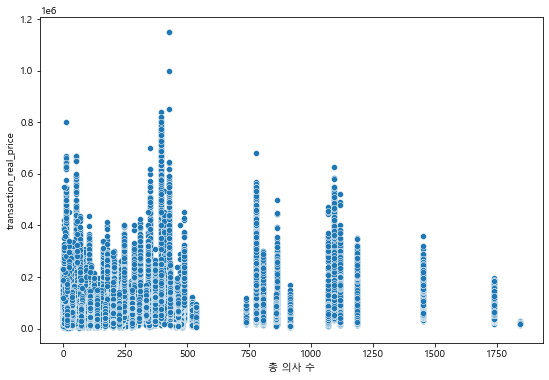

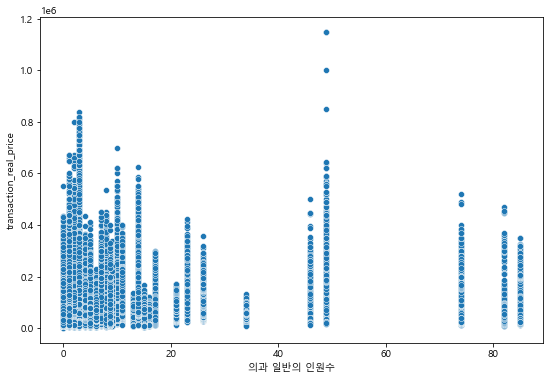

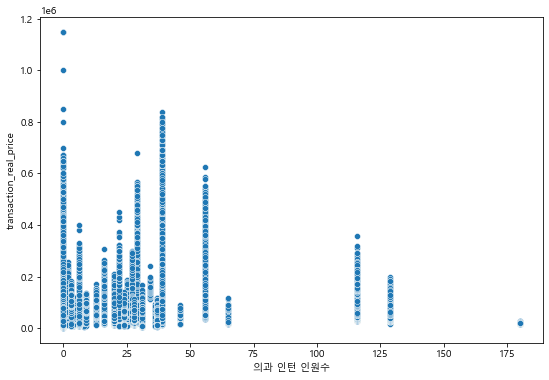

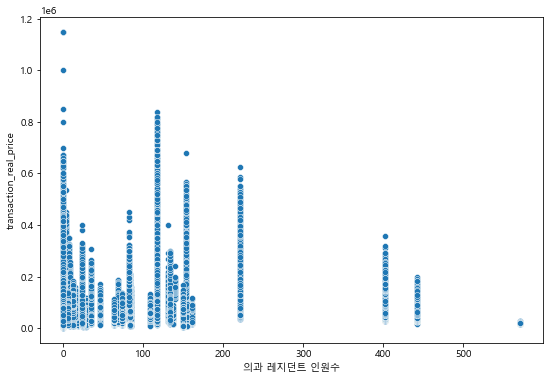

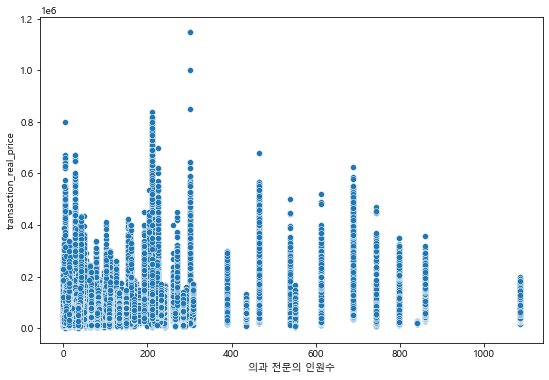

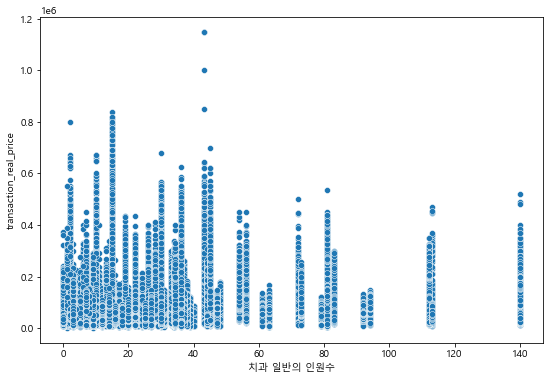

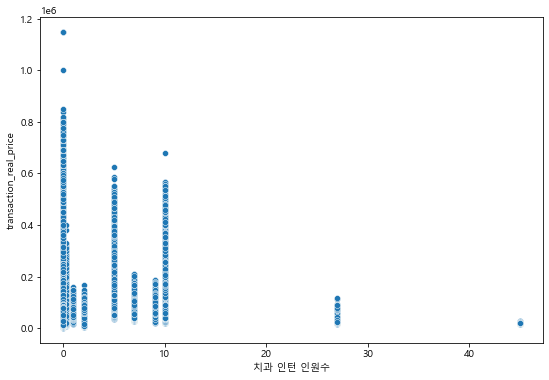

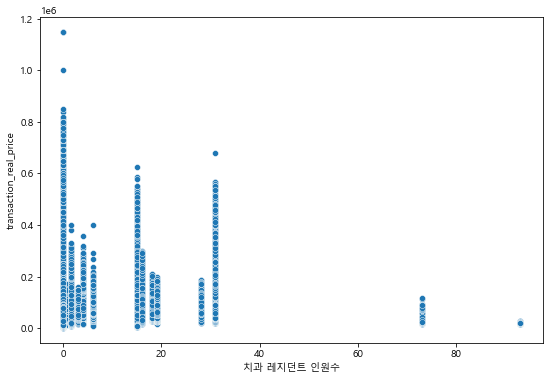

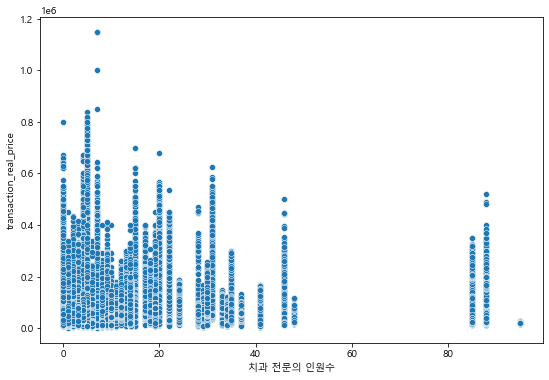

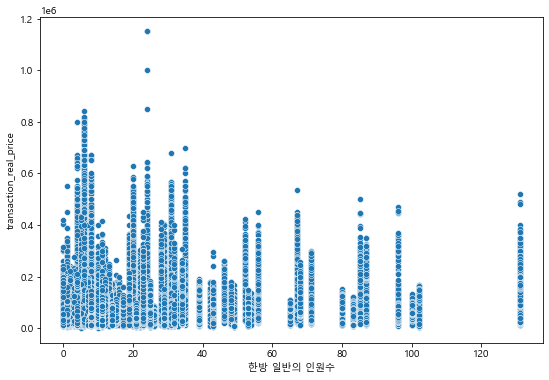

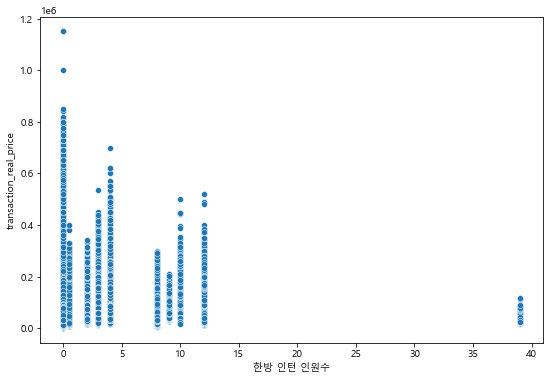

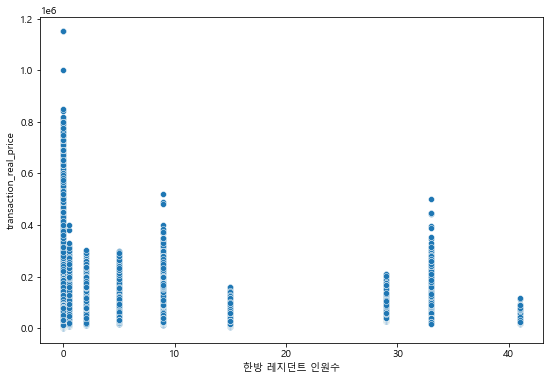

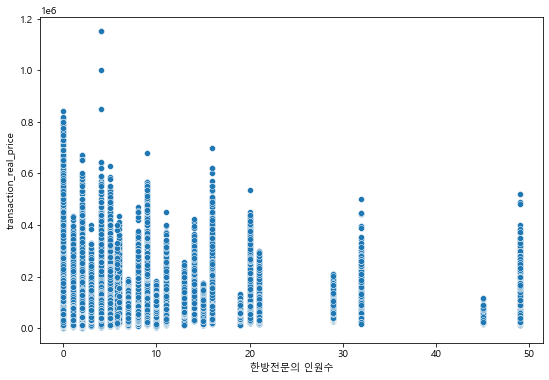

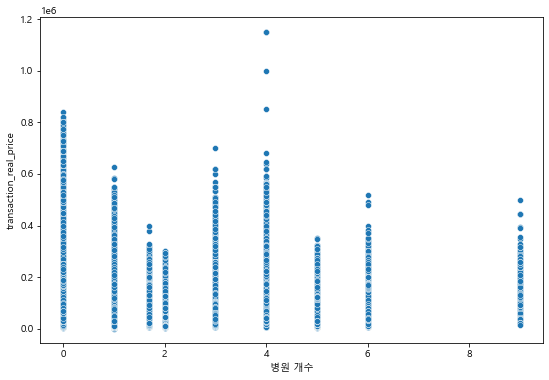

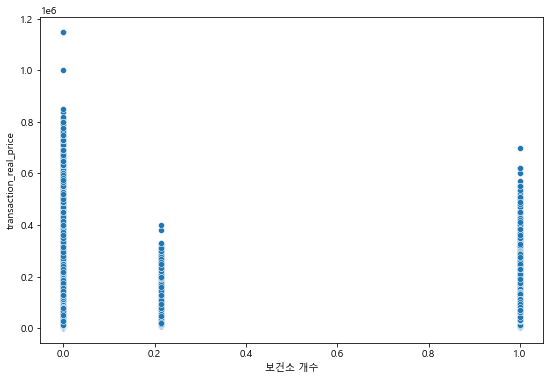

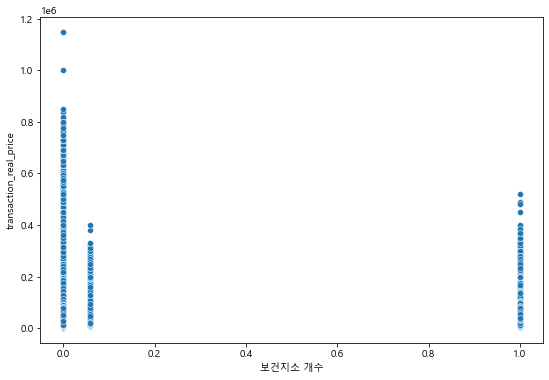

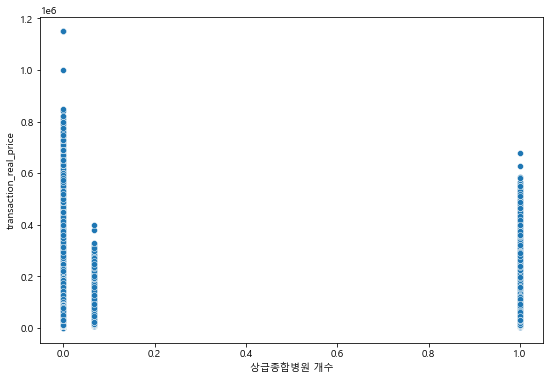

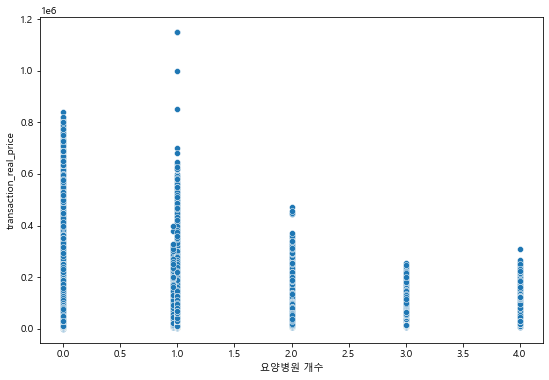

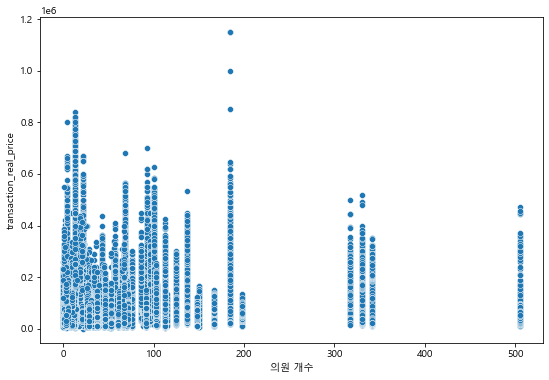

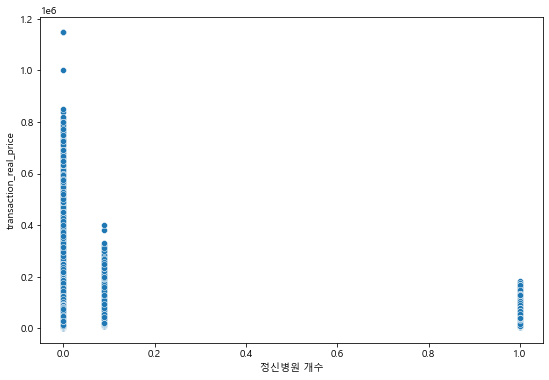

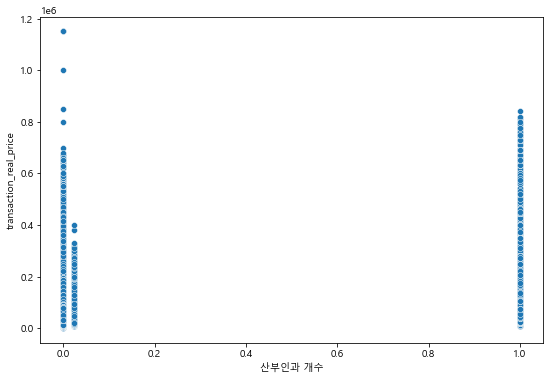

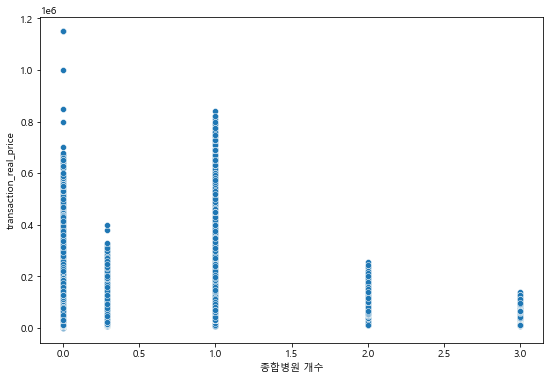

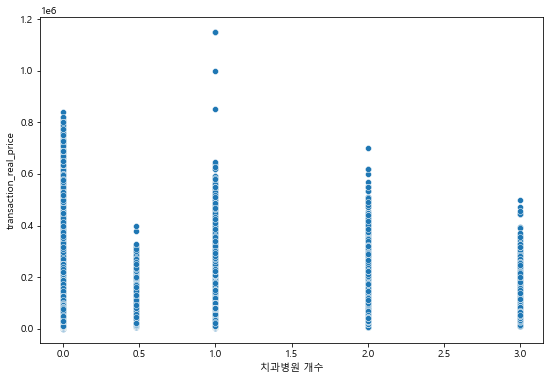

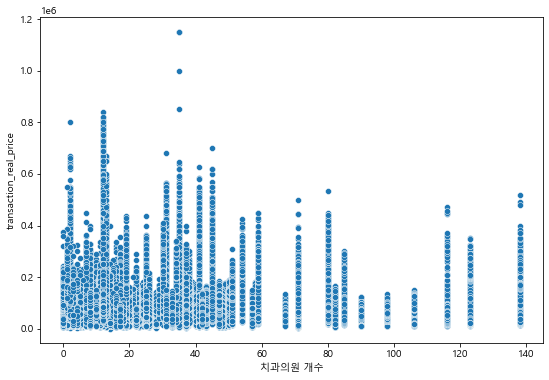

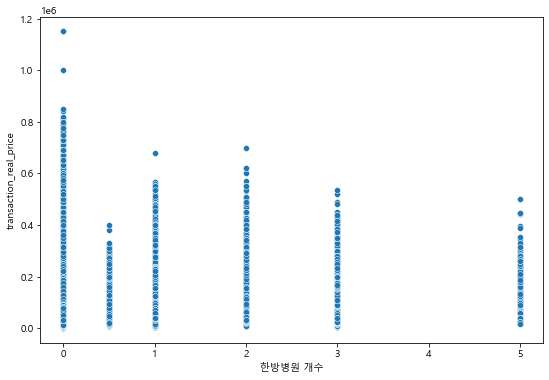

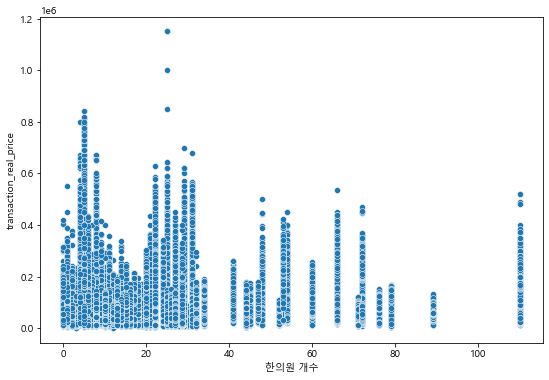

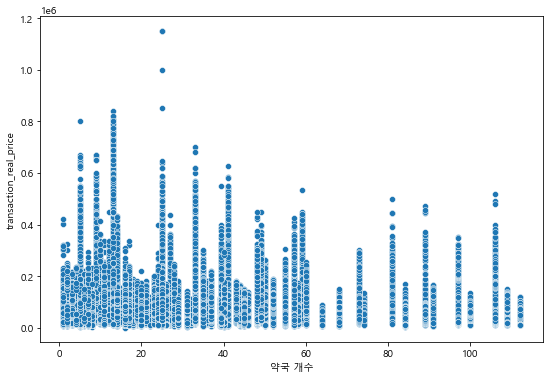

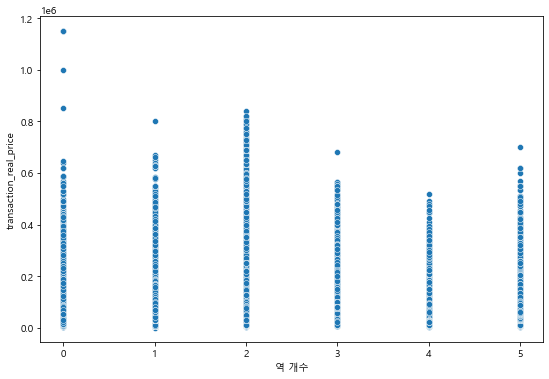

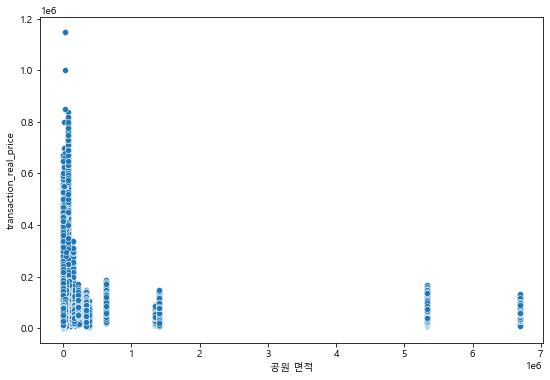

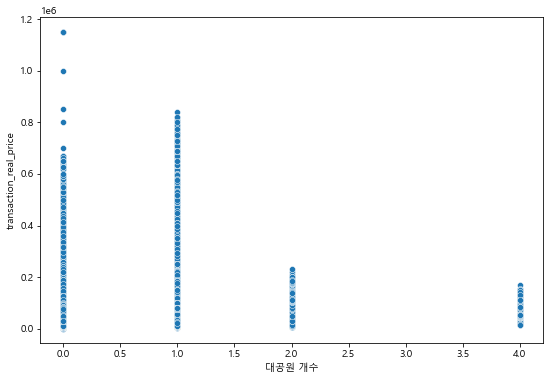

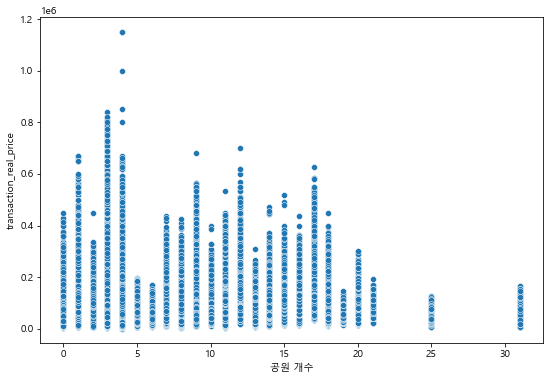

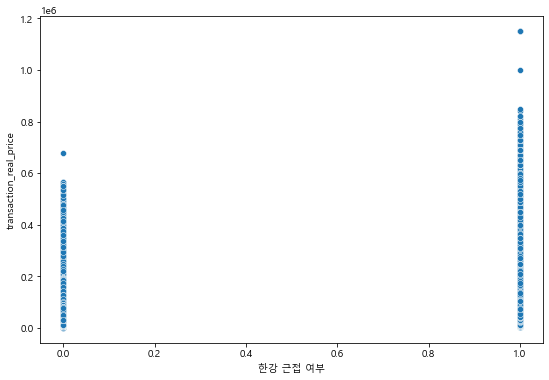

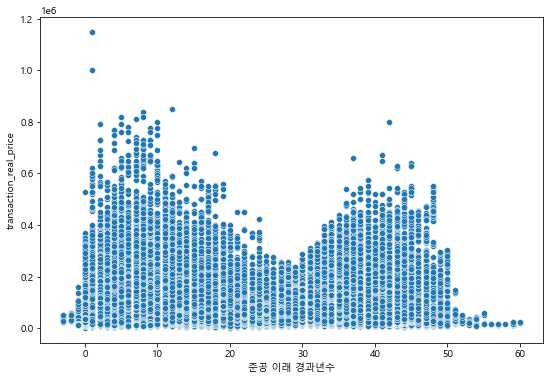

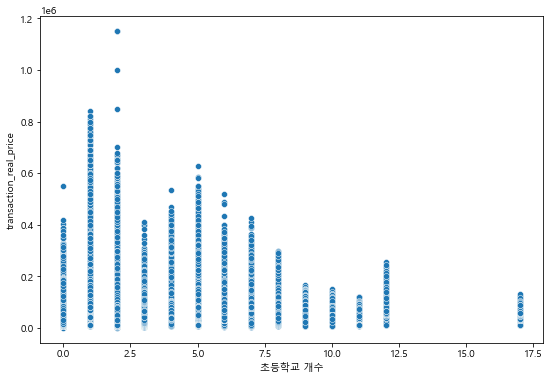

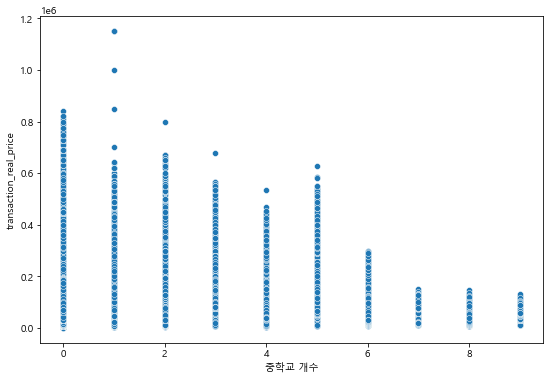

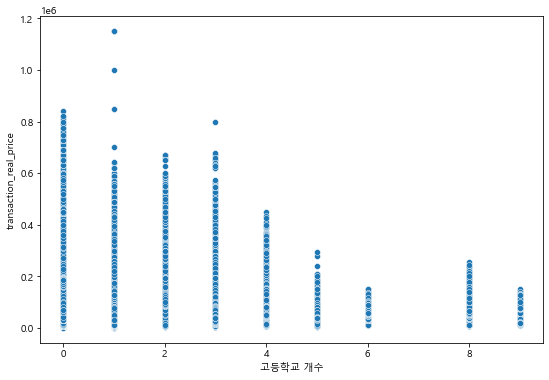

In [19]:
for column in df_temp_temp.columns:
    plt.figure(figsize = (9, 6))
    sns.scatterplot(x = df_temp_temp[column], y = df_temp_temp['transaction_real_price'])
    plt.show()

In [26]:
for i in range(9):
    print(i, '=', df_temp_temp[df_temp_temp['고등학교 개수'] == i]['transaction_real_price'].mean())

0 = 65997.92587077868
1 = 67391.63145991789
2 = 73899.52206563241
3 = 66435.67978378666
4 = 90700.7630071395
5 = 45220.77988475213
6 = 40756.031944481234
7 = nan
8 = 52007.21090196078


In [35]:
df_temp[df_temp_temp['고등학교 개수'] == 5]['dong'].value_counts()

월계동    9151
시흥동    6148
신당동    4348
상일동    2147
망우동    1496
갈현동    1179
Name: dong, dtype: int64

In [ ]:
df_temp[df_temp_temp['고등학교 개수'] == 5]['dong'].value_counts()

In [36]:
df_temp[df_temp_temp['고등학교 개수'] == 6]['dong'].value_counts()

상계동    23882
미아동     7609
등촌동     6084
궁동       178
Name: dong, dtype: int64

In [37]:
df_temp[df_temp_temp['고등학교 개수'] == 7]['dong'].value_counts()

Series([], Name: dong, dtype: int64)

In [38]:
df_temp[df_temp_temp['고등학교 개수'] == 8]['dong'].value_counts()

중계동     13917
신정동     12907
신림동      7737
내발산동     3689
Name: dong, dtype: int64

In [39]:
df_temp[df_temp_temp['고등학교 개수'] == 9]['dong'].value_counts()

봉천동    11013
Name: dong, dtype: int64

In [40]:
df_temp[df_temp_temp['고등학교 개수'] == 10]['dong'].value_counts()

Series([], Name: dong, dtype: int64)

In [41]:
df_temp[df_temp_temp['초등학교 개수'] == 17]['dong'].value_counts()

상계동    23882
Name: dong, dtype: int64

In [42]:
# 학교 수가 많을 수록 가격이 싼 이유
# 땅값이 싼 곳에 학교를 짓기 때문?!
# 땅이 비싼곳에 주거공간을 짓고, 땅이 싼곳에 학교를 짓는 걸 수도 있음

In [ ]:
# x축 = 시간
# y축 = column


In [22]:
df_temp_temp[df_temp_temp['floor']==-2]

exclusive_use_area  year_of_completion  floor  transaction_real_price  \
113411            134.5100                2010     -2                   55181   
113419            134.5100                2010     -2                   56472   
113437            134.7100                2010     -2                   57698   
113438            167.7500                2010     -2                   74466   
153166             84.7100                2014     -2                   47150   
153171             84.8700                2014     -2                   45500   
220865            240.2300                2011     -2                  624000   
220993            240.3050                2011     -2                  558000   
221007            240.3050                2011     -2                  620000   
224620            134.7100                2010     -2                   58767   
358906             84.9500                2013     -2                   56500   
408712            240.2300                2011     -2                  600000   
408727            240.3050                2011     -2                  620000   
411938            134.4800                2010     -2                   60000   
411964            134.4800                2010     -2                   76000   
466276             76.6600                2016     -2                  151000   
485684            240.2300                2011     -2                  630000   
485740            240.2300                2011     -2                  630000   
517314             84.7800                2014     -2                   67700   
549567             76.6600                2016     -2                  167500   
549579            107.9900                2016     -2                  220000   
551650             59.8946                2019     -2                   74500   
571394            101.9900                2010     -2                   94700   

        소비자태도  현재생활형편  미래생활형편  현재경기판단  미래경기판단  내구재구입태도  주택구입태도  현재소비지출  \
113411   90.6    81.0    94.9    55.6    80.0     88.0    98.2   112.5   
113419   90.6    81.0    94.9    55.6    80.0     88.0    98.2   112.5   
113437   98.3    90.8   101.4    68.9    82.7     90.9    80.5   106.5   
113438   98.3    90.8   101.4    68.9    82.7     90.9    80.5   106.5   
153166   96.5    91.4    97.4    72.2    78.1     86.8    80.6   108.8   
153171   91.1    86.7    93.0    63.4    69.7     85.3    73.4   105.3   
220865   95.0    90.0    99.4    67.1    78.0     84.8    80.2   106.2   
220993   96.5    91.4    97.4    72.2    78.1     86.8    80.6   108.8   
221007   91.1    86.7    93.0    63.4    69.7     85.3    73.4   105.3   
224620   96.5    91.4    97.4    72.2    78.1     86.8    80.6   108.8   
358906   97.8    86.6    96.0    67.3    87.0     91.0    70.1   114.1   
408712   97.8    86.6    96.0    67.3    87.0     91.0    70.1   114.1   
408727   97.8    86.6    96.0    67.3    87.0     91.0    70.1   114.1   
411938   97.3    86.1    96.0    67.1    86.0     90.6    67.4   113.3   
411964   95.9    87.7    93.8    70.4    86.0     84.6    72.6   112.6   
466276   92.7    86.0    88.8    67.8    79.5     82.4    70.0   114.8   
485684   93.7    87.0    90.8    68.9    82.9     82.0    69.5   114.2   
485740   92.2    84.4    88.2    66.7    76.2     84.2    71.0   111.7   
517314   87.9    74.4    93.2    53.1    76.2     79.0    58.5    97.3   
549567   86.1    72.4    91.3    51.7    77.3     77.5    73.5    95.3   
549579   87.9    74.4    93.2    53.1    76.2     79.0    58.5    97.3   
551650   86.1    72.4    91.3    51.7    77.3     77.5    73.5    95.3   
571394   87.9    74.4    93.2    53.1    76.2     79.0    58.5    97.3   

        미래소비지출    순자산  고용상황   물가예상    코스피지수   코스닥지수  코스피200    코스피50  시장금리(콜)  \
113411    96.7   94.2  73.1  130.9  1949.26  591.58  249.88  1611.74     1.99   
113419    96.7   94.2  73.1  130.9  2041.03  650.49  257.28  1636.78     1.83   
113437    94.8   92.4  75.9  130.6  1961.31

In [45]:
df_temp_temp.corr()

exclusive_use_area  year_of_completion     floor  \
exclusive_use_area                1.000000            0.058287  0.115754   
year_of_completion                0.058287            1.000000  0.191206   
floor                             0.115754            0.191206  1.000000   
transaction_real_price            0.578335            0.049989  0.156303   
소비자태도                             0.043387           -0.029208  0.004213   
현재생활형편                            0.044618           -0.054422 -0.002772   
미래생활형편                            0.022754           -0.049934 -0.012162   
현재경기판단                            0.047033           -0.024700  0.007511   
미래경기판단                            0.020898           -0.008847  0.004160   
내구재구입태도                           0.044142           -0.048029 -0.000003   
주택구입태도                            0.013970           -0.076567 -0.016543   
현재소비지출                            0.037282           -0.034681  0.005185   
미래소비지출                            0.035757           -0.028381  0.005766   
순자산                               0.029720           -0.029756 -0.005641   
고용상황                              0.029879           -0.027848  0.002593   
물가예상                              0.022956           -0.001532  0.006108   
코스피지수                            -0.012293            0.059907  0.010734   
코스닥지수                            -0.011914            0.054569  0.003566   
코스피200                           -0.014841            0.068373  0.013366   
코스피50                            -0.017260            0.075413  0.015051   
시장금리(콜)                           0.022817           -0.065119 -0.007166   
주택매매가격지수                         -0.036030            0.085875  0.013266   
주택전세가격지수                         -0.022088            0.075605  0.013744   
아파트실거래가격지수_서울                    -0.037148            0.090325  0.013611   
아파트실거래가격지수_전국                    -0.036522            0.080956  0.009931   
생산자물가지수                          -0.029803            0.077619  0.014615   
소비자물가지수                          -0.023217            0.087464  0.018356   
주택매매가격지수_서울_아파트                  -0.026121            0.090366  0.016931   
법정동별인구수                          -0.098208           -0.123626 -0.039031   
단기 COFIX                          0.019010           -0.054896 -0.005816   
기준금리                              0.022896           -0.066362 -0.007522   
총 의사 수                            0.022842           -0.121411 -0.012167   
의과 일반의 인원수                        0.021206           -0.056006 -0.007192   
의과 인턴 인원수                        -0.009533           -0.131941 -0.025009   
의과 레지던트 인원수                       0.002286           -0.139113 -0.011979   
의과 전문의 인원수                        0.031147           -0.102218 -0.009400   
치과 일반의 인원수                        0.004200           -0.101008 -0.011457   
치과 인턴 인원수                         0.051372           -0.034331  0.033986   
치과 레지던트 인원수                       0.027577           -0.091854  0.022926   
치과 전문의 인원수                        0.034743           -0.063134  0.000792   
한방 일반의 인원수                       -0.014993           -0.088061 -0.018475   
한방 인턴 인원수                         0.079329           -0.025370 -0.006338   
한방 레지던트 인원수                       0.025234           -0.014406 -0.026880   
한방전문의 인원수                         0.052115           -0.096764 -0.010417   
병원 개수                            -0.016945            0.033697 -0.008544   
보건소 개수                           -0.060347           -0.063098 -0.001119   
보건지소 개수                           0.051081            0.024243 -0.018137   
상급종합병원 개수                         0.054014           -0.036948  0.036418   
요양병원 개수                          -0.115162           -0.094209 -0.040970   
의원 개수                             0.013954           -0.072161 -0.012234   
정신병원 개수                          -0.068856           -0.021741 -0.014133   
산부인과 개수                           0.079525            0.047218  0.005530

In [ ]:
# plt.figure(figsize = (9, 6))
# sns.boxplot(x = 'dong', y = 'transaction_real_price', data = DF)
# plt.show()

In [ ]:
# plt.figure(figsize = (9, 6))
# sns.boxplot(x = 'apt, y = 'transaction_real_price', data = DF)
# plt.show()